firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


/Users/davidpolashenski/Desktop/athabasca_model_inputs/0415_HistExtent.geojson
urn:ogc:def:crs:EPSG::32611
4.819025e+05, 5.781675e+06, 4.841637e+05, 5.784525e+06


Text(0.5, 0, 'meters')

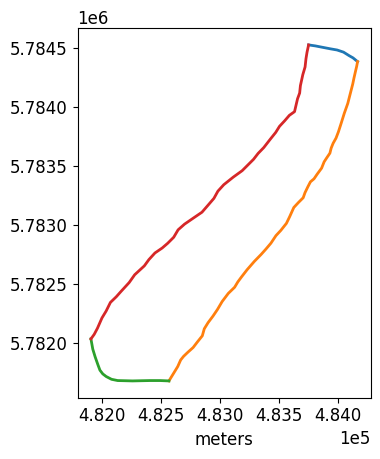

In [1]:
import firedrake
from firedrake import Constant, sqrt, inner, grad, dx
import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import numpy as np
import rasterio
import geojson
import icepack, icepack.plot, icepack.interpolate
#DEFINE SLIDING LAW HERE: WEERTMAN_SLIDING AS M
from icepack.constants import (
    ice_density as ρ_I, gravity as g, weertman_sliding_law as m
)


#Upload the GeoJSON file (Athabasca glacier outline drawn in QGIS)
outline_filename = '/Users/davidpolashenski/Desktop/athabasca_model_inputs/0415_HistExtent.geojson'
print(outline_filename)

with open(outline_filename, 'r') as outline_file:
    outline = geojson.load(outline_file)
print(outline['crs']['properties']['name'])


features = [feature['geometry'] for feature in outline['features']]
xmin, ymin, xmax, ymax = np.inf, np.inf, -np.inf, -np.inf


δ = 0
for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        x, y = xs[:, 0], xs[:, 1]
        xmin, ymin = min(xmin, x.min() - δ), min(ymin, y.min() - δ)
        xmax, ymax = max(xmax, x.max() + δ), max(ymax, y.max() + δ)
        
print(f'{xmin:e}, {ymin:e}, {xmax:e}, {ymax:e}')

fig, axes = icepack.plot.subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')

    


/Users/davidpolashenski/firedrake/src/PyOP2/pyop2/types/glob.py:55: UserWarning: PyOP2.Global has no comm, this is likely to break in parallel!
  warnings.warn("PyOP2.Global has no comm, this is likely to break in parallel!")


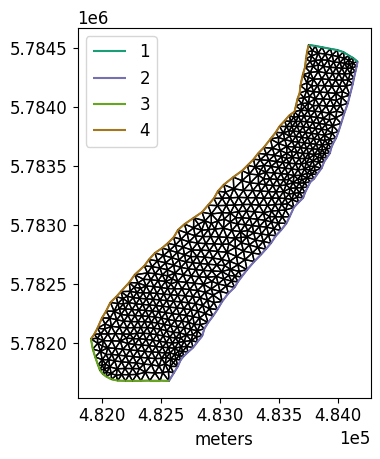

In [2]:
import pygmsh

#convert from GeoJSON, to .geo outline that gmsh can read as an input
geometry = icepack.meshing.collection_to_geo(outline)

with open('athabasca.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())

#mesh the .geo file 
!gmsh -2 -format msh2 -v 2 -o athabasca.msh athabasca.geo
#!gmsh -2 -format msh2 -o athabasca.msh athabasca.geo

#make a 2D footprint mesh and extrude it 
mesh2d = firedrake.Mesh('athabasca.msh')
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

#plot mesh of the model domain
fig, axes = icepack.plot.subplots()
axes.set_xlabel('meters')
icepack.plot.triplot(mesh2d, axes=axes)

#legend with four boundary conditions; 1=front, 2 and 4=sides, 3=icefall
axes.legend(loc = "upper left")

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


/Users/davidpolashenski/firedrake/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


Text(0.5, 0, 'meters')

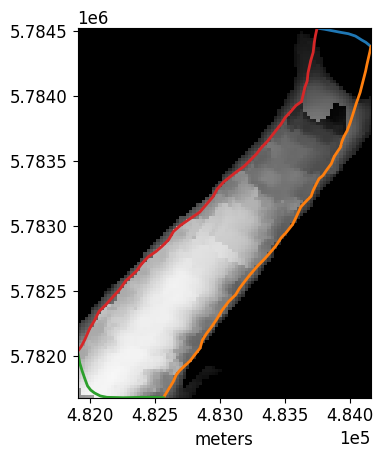

In [3]:

#GPR survey thickness data with farinotti filling holes
thickness_filename = ('/Users/davidpolashenski/Desktop/Athabasca_Model_Inputs/Thickness_GPR_Faranotti.tif')
thickness_file = rasterio.open(thickness_filename, 'r')
thickness = thickness_file.read()

print(thickness)

#window the ice thickness data
height, width = thickness_file.height, thickness_file.width
transform = thickness_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform
)

#plot ice thickness
thickness = thickness_file.read(indexes=1, window=window, masked=True)

def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        thickness,
        cmap='Greys_r',
        vmin=0,
        vmax=301,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

#overlay outline
for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')




[[[-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  ...
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]]]


Text(0.5, 0, 'meters')

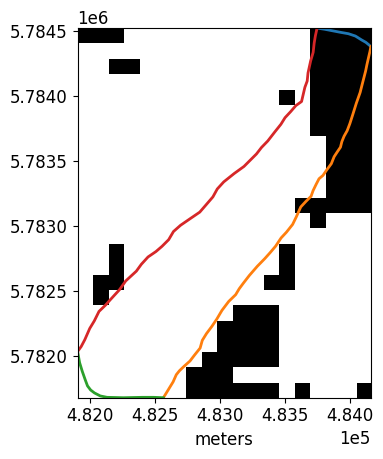

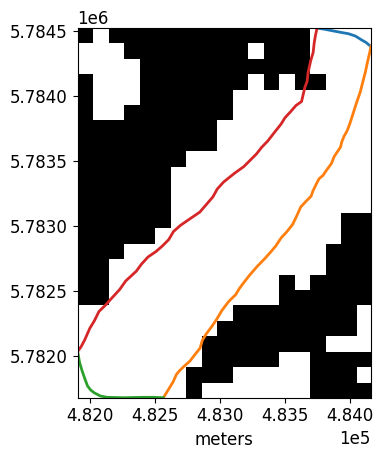

In [4]:
#Add Landsat vx and vy data over the domain


#Landsat vx data annual average m/yr
vx_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/l8_velo_vx_ma_140%.tif')
vx_file = rasterio.open(vx_filename, 'r')
vx = vx_file.read()

height, width = vx_file.height, vx_file.width
transform = vx_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
vx = vx_file.read(indexes=1, window=window, masked=True)

def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        vx,
        cmap='Greys_r',
        vmin=0,
        vmax=0.1,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')

#Landsat vy data annual average m/yr
vy_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/l8_velo_vY_ma_140%.tif')
vy_file = rasterio.open(vy_filename, 'r')
vy = vy_file.read()

print(vy)

height, width = vy_file.height, vy_file.width
transform = vy_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
vy = vy_file.read(indexes=1, window=window, masked=True)

#Define a windowing subplot function, vmin/max definies colorbar scale
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        vy,
        cmap='Greys_r',
        vmin=0,
        vmax=.1,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')

In [5]:
from pandas import read_csv

#read in historical surface velocity observations from Paterson 1963 (and Armstrong et al. 2022 JGR)
d = read_csv("/Users/davidpolashenski/Desktop/Athabasca_Model_Inputs/0413_Point_velocities.csv")
d
pv = np.array(d)
pv

pv_coord = (pv[:,[0,1]])
#pv_coord

/Users/davidpolashenski/firedrake/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[[65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 ...
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]]
[16 26 27 27 22 26 27 27 29 32 33 33 33 33 33 33 29 33 25 33 19 32 34 34
 35 29 38 24 35 41 42 43 44 43 47 39 50 30 13 52 55 57 58 59]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]
[[ 481901. 5784531.]
 [ 481901. 5784521.]
 [ 481901. 5784511.]
 ...
 [ 484151. 5781711.]
 [ 484151. 5781701.]
 [ 484151. 5781691.]]
64410
[[  1 249]
 [  1 250]
 [  1 251]
 ...
 [225  18]
 [225  19]
 [225  20]]
[[ 481911. 5782041.]
 [ 481911. 5782031.]
 [ 481911. 5782021.]
 ...
 [ 484151. 5784351.]
 [ 484151. 5784341.]
 [ 484151. 5784331.]]
19798
[[4.82117466e+05 5.78174612e+06 1.00000000e+00]
 [4.82032091e+05 5.78180470e+06 1.00000000e+00]
 

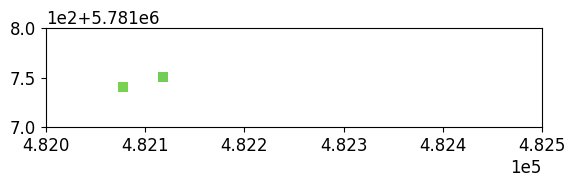

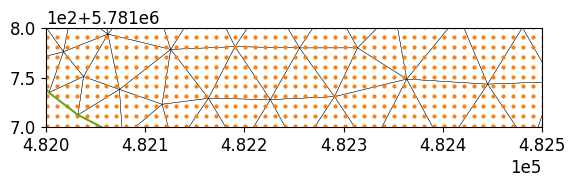

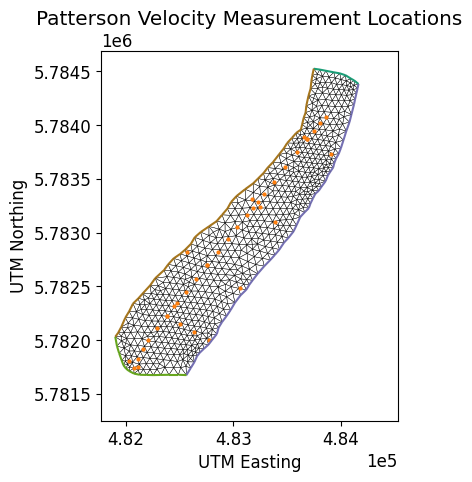

In [6]:
Pat_velocity_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/Paterson_PointVelocities.tif')

Pat_velocity_file = rasterio.open(Pat_velocity_filename, 'r')
Pat_velocity = Pat_velocity_file.read()

height, width = Pat_velocity_file.height, Pat_velocity_file.width
transform = Pat_velocity_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
Pat_velocity = Pat_velocity_file.read(indexes=1, window=window, masked=True)


print(Pat_velocity.data)


#py, px = Pat_velocity.index[~Pat_velocity.mask]

output = Pat_velocity.data[~Pat_velocity.mask]
print(output)


print(Pat_velocity)
#print(xnan)

#Define a windowing subplot function, vmin/max definies colorbar scale
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        Pat_velocity,
        cmap='viridis',
        vmin=0,
        vmax=74,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()
axes.set_xlim((4.82e5, 4.825e5))
axes.set_ylim((5.7817e6, 5.7818e6))
#fig.colorbar(colors);



window = rasterio.windows.from_bounds(
    left=xmin,
    bottom=ymin,
    right=xmax,
    top=ymax,
    transform=Pat_velocity_file.transform,
).round_lengths().round_offsets()
transform = Pat_velocity_file.window_transform(window)

xs = np.array(
    [
        transform * (i, j)
        for i in range(window.width)
        for j in range(window.height)
    ]
)

fig, axes = subplots()
icepack.plot.triplot(mesh2d, axes=axes, interior_kw={"linewidth": 0.25})
axes.set_xlim((4.82e5, 4.825e5))
axes.set_ylim((5.7817e6, 5.7818e6))
axes.scatter(xs[:, 0], xs[:, 1], 4.0, "tab:orange");

print(xs)
print(len(xs))


indices = np.array(
    [
        (i, j)
        for i in range(window.width)
        for j in range(window.height)
        if mesh2d.locate_cell(transform * (i, j))
    ]
)

print(indices)


xs = np.array([transform * idx for idx in indices])
print(xs)
print(len(xs))

#append a column of ones (depth of one-layer extruded mesh), to xs so the the point set dimensions (3, x,y,z) 
#matches the 3D extruded mesh dimensions after finding the points using locate_cell on 2D mesh above
#new_col = xs.sum(1)[...,None]
#xs = np.append(xs, np.ones([len(xs),1]), 1)
pv_coord = np.append(pv_coord, np.ones([len(pv_coord),1]), 1)
print(pv_coord)
print(len(pv_coord))

fig, axes = subplots()
icepack.plot.triplot(mesh2d, axes=axes, interior_kw={"linewidth": 0.25})
axes.scatter(pv_coord[:, 0], pv_coord[:, 1], 4.0, "tab:orange");
axes.set_title('Patterson Velocity Measurement Locations')
#colors = icepack.plot.tripcolor(h_change, axes=axes)
#fig.colorbar(colors,label="Thickness Change (meters)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure35.png',dpi=1500, facecolor='w', edgecolor='w',)

#b = numpy.append(a,numpy.zeros([len(a),1]),1)


#need to pass a point set that includes only the values/locations of the 48 observed velocity data on the mesh
point_set = firedrake.VertexOnlyMesh(
    mesh, pv_coord, missing_points_behaviour="error"
)

In [7]:
#create function spaces for the point velocity data set

Δ = firedrake.FunctionSpace(point_set, "DG", 0)

vel_point = firedrake.Function(Δ)

Pat_velocity = Pat_velocity_file.read(indexes=1, window=window)
#Pat_velocity = np.ma.filled(Pat_velocity.astype(float), np.nan)



#vel_point.dat.data[:] = Pat_velocity[indices[:, 1], indices[:, 0]]
vel_point.dat.data[:] = np.ravel((pv[:,[2]]))

#print(Pat_velocity)
#print(~np.isnan(Pat_velocity))
print(np.unique(Pat_velocity[~np.isnan(Pat_velocity)]))
print(vel_point)

#Pat_velocity=Pat_velocity.astype('float')
#Pat_velocity[Pat_velocity == --] = np.NAN

print(np.unique(Pat_velocity[~np.isnan(Pat_velocity)]))

N = np.sum(~np.isnan(Pat_velocity))
N

[   13    16    19    22    24    25    26    27    29    30    32    33
    34    35    38    39    41    42    43    44    47    50    52    55
    57    58    59 65535]
w₂₁
[   13    16    19    22    24    25    26    27    29    30    32    33
    34    35    38    39    41    42    43    44    47    50    52    55
    57    58    59 65535]


64410

/Users/davidpolashenski/firedrake/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


[1916.6985 1916.826  1917.0596 ... 2701.0217 2701.1565 2701.9055]
[1916.6985 1916.826  1917.0596 ... 2701.0217 2701.1565 2701.9055]


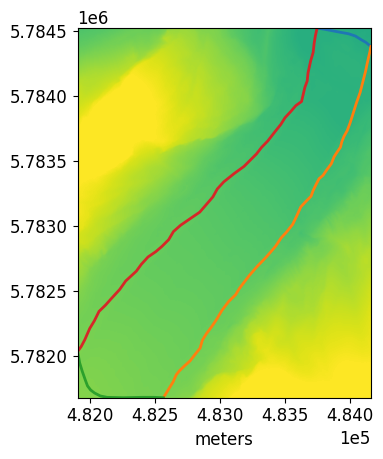

In [8]:
#Input surface elevation/DEM of glacier surface; modern lidar DEM
DEM_mod_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/Athabasca_DEM.tif')

DEM_mod_file = rasterio.open(DEM_mod_filename, 'r')
DEM_mod = DEM_mod_file.read()

height, width = DEM_mod_file.height, DEM_mod_file.width
transform = DEM_mod_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
DEM_mod = DEM_mod_file.read(indexes=1, window=window, masked=True)

#read the elevation data out of masked array format from input file
DEM_mod = np.ma.getdata(DEM_mod)

#not sure how to add colorbar here...
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        DEM_mod,
        cmap='viridis',
        vmin=1000,
        vmax=2500,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')
DEM_mod

print(np.unique(DEM_mod[~np.isnan(DEM_mod)]))
print(np.unique(DEM_mod))

[-32767.       1927.2944   1927.4501 ...   2680.6943   2681.2495
   2681.2522]
[-32767.       1927.2944   1927.4501 ...   2680.6943   2681.2495
   2681.2522]


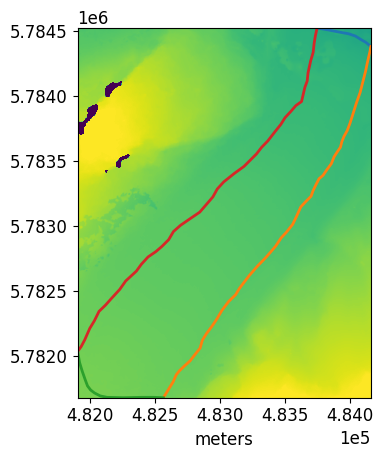

In [9]:

#Input surface elevation/DEM of glacier surface; historical, aerial DEM
DEM_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/dem1966_resample5m_clipOutMidGlacierSeam_fillNan10px.tif')

DEM_file = rasterio.open(DEM_filename, 'r')
DEM = DEM_file.read()

height, width = DEM_file.height, DEM_file.width
transform = DEM_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
DEM = DEM_file.read(indexes=1, window=window, masked=True)

#read the elevation data out of masked array format from input file
DEM = np.ma.getdata(DEM)

#not sure how to add colorbar here...
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        DEM,
        cmap='viridis',
        vmin=1000,
        vmax=2600,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')
DEM

# code to replace all negative elevation values with 0
#DEM[DEM<0] = 2260
#DEM

print(np.unique(DEM[~np.isnan(DEM)]))
print(np.unique(DEM))


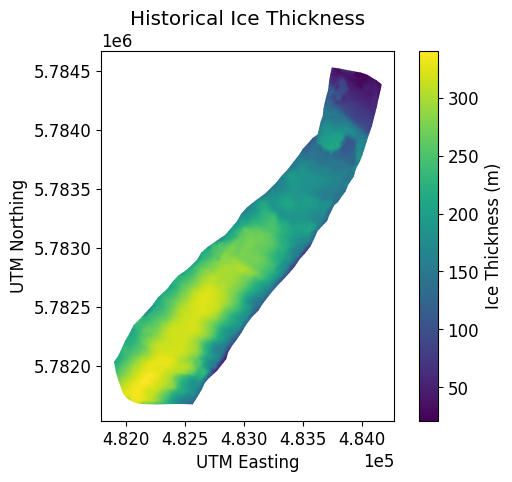

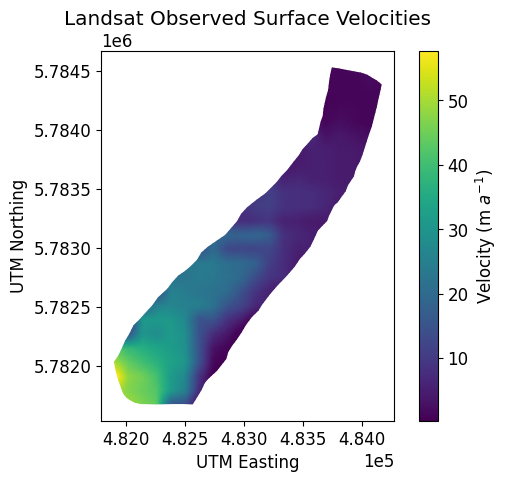

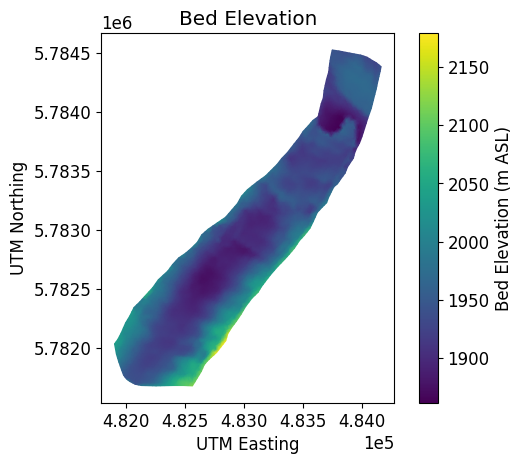

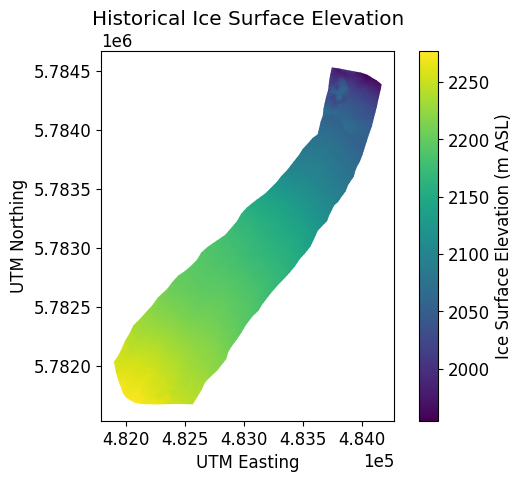

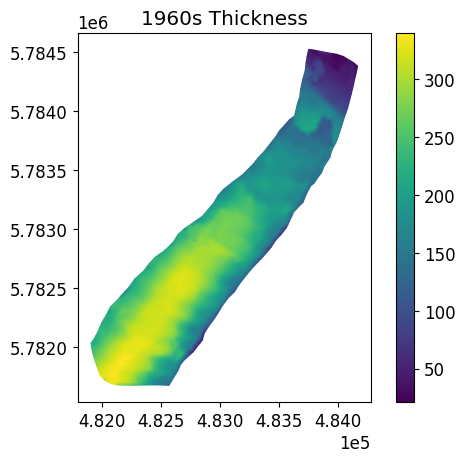

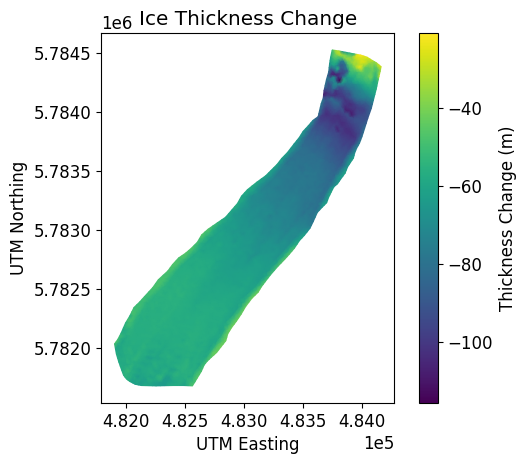

In [10]:

#set up function space and vector function space as shown in Beardmore and Hybrid xyz tutorials
Q = firedrake.FunctionSpace(mesh, family="CG", degree=2, vfamily="R", vdegree=0)


#Q = firedrake.FunctionSpace(mesh, family="CG", degree=1, vfamily="R", vdegree=0)
V = firedrake.VectorFunctionSpace(mesh,"CG", 2, dim=2, vfamily="GL", vdegree=2)

#use this for symbolic variables in gradient to calculate strain rate



#use this to calculate a map view driving stress (otherwise dimenesions below don't work)
V2 = firedrake.VectorFunctionSpace(mesh, family="CG", degree=2, vfamily="R", vdegree=0)


from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    weertman_sliding_law as m,
    gravity as g,
)

x, y, ζ = firedrake.SpatialCoordinate(mesh)


#interpolate thickness and DEM to the 2D mesh footprint grid only
h0 = icepack.interpolate(thickness_file, Q)
s0 = icepack.interpolate(DEM_mod_file, Q)
s_hist = icepack.interpolate(DEM_file,Q)
b0 = icepack.interpolate(s0-h0, Q)
h_hist = icepack.interpolate(s_hist-b0,Q)
h_change = icepack.interpolate(h0-h_hist,Q)

#interpolate the vx/vy vectors onto extruded vector function space, as in Beardmore/Hybrid xyz tutorials
#initial guess is modern velocity field from satellite record; not sure how to scale it appropriately
u_initial = (icepack.interpolate((vx_file, vy_file), V))
#u_initial = icepack.interpolate((vx_file, vy_file), V2)


#plot interpolated thickness and velocity to make sure they're sensible

#plot thickness
fig, axes = icepack.plot.subplots()
axes.set_title('Historical Ice Thickness')
colors = icepack.plot.tripcolor(h_hist, axes=axes)
fig.colorbar(colors,label="Ice Thickness (m)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure33.png',dpi=1500, facecolor='w', edgecolor='w',)


#plot velocity
fig, axes = icepack.plot.subplots()
axes.set_title('Landsat Observed Surface Velocities')
colors = icepack.plot.tripcolor(u_initial, axes=axes)
fig.colorbar(colors,label="Velocity (m $a^{-1}$)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure34.png',dpi=1500, facecolor='w', edgecolor='w',)

#plot velocity
fig, axes = icepack.plot.subplots()
axes.set_title('Bed Elevation')
colors = icepack.plot.tripcolor(b0, axes=axes)
fig.colorbar(colors,label="Bed Elevation (m ASL)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure35.png',dpi=1500, facecolor='w', edgecolor='w',)

#plot historical thickness
fig, axes = icepack.plot.subplots()
axes.set_title('Historical Ice Surface Elevation')
colors = icepack.plot.tripcolor(s_hist, axes=axes)
fig.colorbar(colors,label="Ice Surface Elevation (m ASL)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure36.png',dpi=1500, facecolor='w', edgecolor='w',)


#plot historical thickness
fig, axes = icepack.plot.subplots()
axes.set_title('1960s Thickness')
colors = icepack.plot.tripcolor(h_hist, axes=axes)
fig.colorbar(colors);
plt.show()

#plot thickness change
fig, axes = icepack.plot.subplots()
axes.set_title('Ice Thickness Change')
colors = icepack.plot.tripcolor(h_change, axes=axes)
fig.colorbar(colors,label="Thickness Change (m)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure37.png',dpi=1500, facecolor='w', edgecolor='w',)



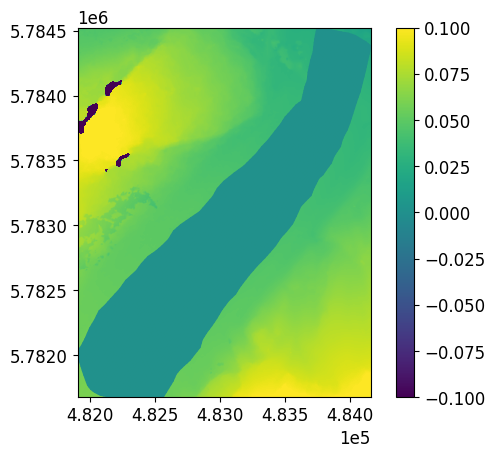

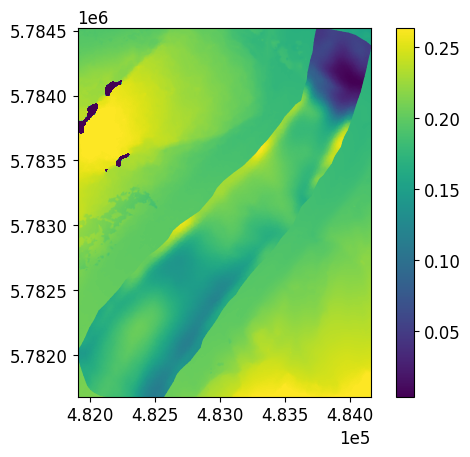

In [11]:
#create smoothed driving stress to 'guess' the initial friction coefficient
#modifying alpha here changes how smoothed the driving stress is
α = Constant(10e1)
τ = firedrake.Function(V2)


fig, axes = subplots()
colors = icepack.plot.tripcolor(τ, axes=axes)
fig.colorbar(colors);


τ_d = -ρ_I * g * h_hist * grad(s0)
misfit = 0.5 * inner(τ - τ_d, τ - τ_d) * dx
smoothness = 0.5 * α ** 2 * inner(grad(τ), grad(τ)) * dx
J = misfit + smoothness
F = firedrake.derivative(J, τ)
firedrake.solve(F == 0, τ)


fig, axes = subplots()
colors = icepack.plot.tripcolor(τ, axes=axes)
fig.colorbar(colors);


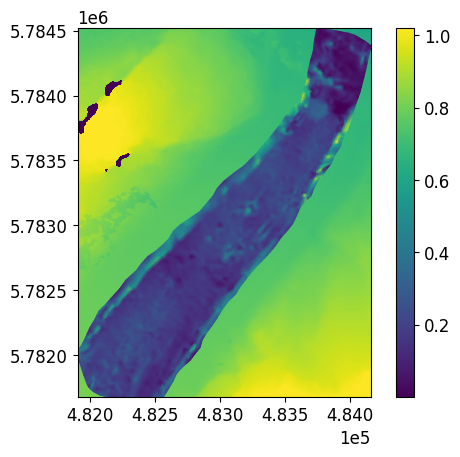

In [12]:
#calculate and plot driving stress (unsmoothed)
τ_driving = firedrake.interpolate(-ρ_I * g * h_hist * grad(s0),V2)

fig, axes = subplots()
colors = icepack.plot.tripcolor(τ_driving, axes=axes)
fig.colorbar(colors);

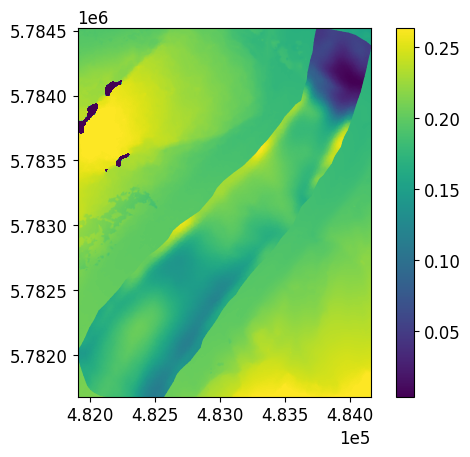

In [13]:
fig, axes = subplots()
colors = icepack.plot.tripcolor(τ, axes=axes)
fig.colorbar(colors);


85.23841872784968


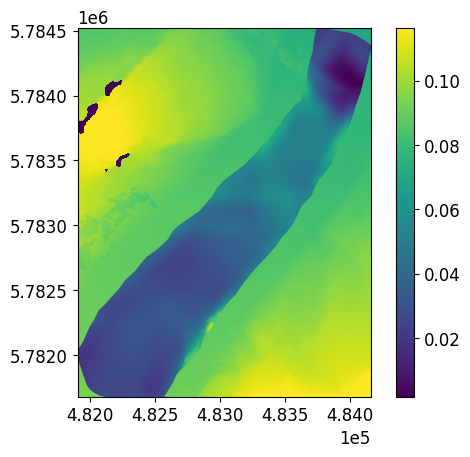

In [14]:

#Estimate fraction of the driving stress that the basal friction takes up, here 0.5 or 50%
fraction = Constant(0.5)
expr = fraction * sqrt(inner(τ, τ)) / sqrt(inner(u_initial, u_initial)) ** (1 / m)
C = firedrake.interpolate(expr, Q)
area = firedrake.assemble(Constant(1.0) * dx(mesh))
C_0 = Constant(firedrake.assemble(C * dx) / area)


fig, axes = subplots()
colors = icepack.plot.tripcolor(C, axes=axes)
fig.colorbar(colors);


#Rate factor, A, calculated automatically in viscosity.py based upon ice temperature given here
T = Constant(270.4)
A = icepack.rate_factor(T)

#just to see/print what rate factor A is being used
T_test = 270.4
A_test = icepack.rate_factor(T_test)

print(A_test)

#2.4*10^-24*10^6*10^6*10^6*3600*24*365; unit conversion for rate factor Pa^-n/s to mPa^-n/yr
#0.085/10^5/10^5/10^5/365/24/3600; unit conversion for rate factor; bar^-n/yr to Pa^-n/s


In [15]:


#define a Weertman type friction law
def friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    #C = kwargs["friction"]
    θ = kwargs["log_friction"]
    C = C_0 * firedrake.exp(θ)

    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    
    return icepack.models.hybrid.bed_friction(
        velocity=u,
        friction=C * ϕ,
    )

In [16]:
model = icepack.models.HybridModel(friction=friction)
opts = {
    "dirichlet_ids": [1,3],
    "side_wall_ids": [2, 4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)


In [17]:
#set up variable for log friction, (ln(C))
θ = firedrake.Function(Q)

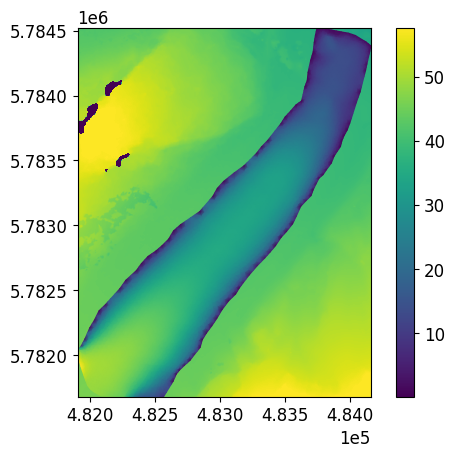

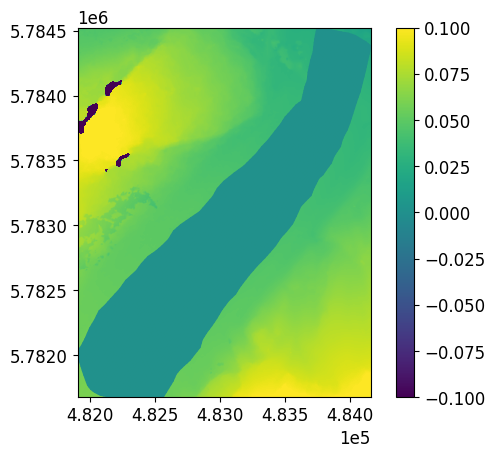

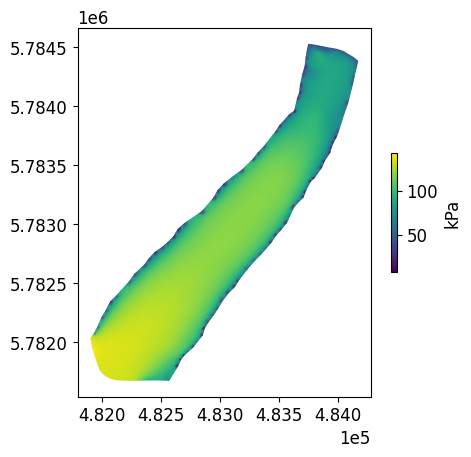

In [18]:
u = solver.diagnostic_solve(
    velocity=u_initial,
    thickness=h_hist,
    surface=s_hist,
    fluidity=A,
    #friction=C,
    log_friction=θ,
)

fig, axes = subplots()
colors = icepack.plot.tripcolor(u,axes=axes)
fig.colorbar(colors);

fig, axes = subplots()
colors = icepack.plot.tripcolor(θ, axes=axes)
fig.colorbar(colors);


C = C_0 * firedrake.exp(θ)


#Calculate basal shear stress
#expr = -1e3 * C * ϕ * sqrt(inner(u0, u0)) ** (1 / m - 1) * u0
expr = -1e3 * C * sqrt(inner(u, u)) ** (1 / m - 1) * u
τ_b = firedrake.interpolate(expr, V)
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ_b, axes=axes)
fig.colorbar(colors, label="kPa", fraction=0.012, pad=0.04);


In [19]:
from firedrake import assemble, Constant, inner, grad, dx

def simulation(θ):
#def simulation(C):
    return solver.diagnostic_solve(
        velocity=u_initial,
        thickness=h_hist,
        surface=s_hist,
        fluidity=A,
        #friction=C,
        log_friction=θ,
    )

σx = Constant(2.0)
σy = Constant(2.0)


N = len(pv_coord)
print(N)

u_magnitude = (((u[0])**2)+((u[1])**2))**0.5
#print(u_magnitude)
    
#interpolate the velocity magnitude solution onto the function space for the velocity point data
u_interp = firedrake.interpolate(u_magnitude, Δ)
    
#calculate misfit between the modeled velocity magnitudes and the observed Paterson point velocities
δu = u_interp - vel_point

initial_misfit = assemble(0.5 * ((δu / σx)**2) * dx) / N
print(initial_misfit)


u_interp = firedrake.interpolate(u[0], Δ)
v_interp = firedrake.interpolate(u[1], Δ)

u_magnitude = (((u_interp)**2)+((v_interp)**2))**0.5

δu = u_magnitude - vel_point
#print(δu)

square_error = (δu / σx)**2 




#define the loss functional based upon Patterson point data as observed velocities
def loss_functional(u):
    #calculate the magnitude of velcocity vector (squareroot of vx squared plus vy squared) to compare to observed point
    #data velocity values from Patterson 
    u_magnitude = (((u[0])**2)+((u[1])**2))**0.5
    
    #interpolate the velocity magnitude solution onto the function space for the velocity point data
    u_interp = firedrake.interpolate(u_magnitude, Δ)
    
    #calculate misfit between the modeled velocity magnitudes and the observed Paterson point velocities
    δu = u_interp - vel_point
    #δu = firedrake.interpolate(sqrt(inner(u_interp - vel_point, u_interp - vel_point)), Δ)
    
    return 0.5 / Constant(N) * ((δu / σx)**2) * dx

print(assemble(loss_functional(u)))

#set the alpha/L parameter in regularization function
L = Constant(200)
def regularization(θ):
    return 0.5 * L**2 / Constant(area) * inner(grad(θ), grad(θ)) * dx


40
6.990666754657933
6.990666754657933


In [20]:
from icepack.statistics import StatisticsProblem, MaximumProbabilityEstimator

problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    #controls=C,
    controls=θ,
)

In [21]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-3,
    step_tolerance=1e-1,
    max_iterations=30,
)
#C = estimator.solve()
θ = estimator.solve()

#converged once with n = 3.0 in for rate factor in icepack source code




Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     6.990667e+00   1.033906e-02                  3.424846e+02   
  1     4.863768e+00   7.811429e-03   3.424846e+02   8.562115e+02   3         2         0         1         3         
  2     4.863768e+00   7.811429e-03   8.562115e+02   5.351322e+01   4         2         2         14        3         
  3     4.644239e+00   7.730768e-03   5.351322e+01   1.337831e+02   5         3         0         2         3         
  4     4.261995e+00   1.206824e-02   1.337831e+02   3.344576e+02   6         4         0         4         3         
  5     3.665771e+00   5.320636e-03   3.344576e+02   8.361441e+02   7         5         0         7         3         
  6     3.253627e+00   1.649270e-03   4.197190e+02   2.090360e+03   8         6         0         20        1         
  7     3.158198e+00   1.470199e-03   2.654606e+02   5.225900e+0

587.1418008878348
-74.2254311527815
126.96217228165811
141.21797399925782
[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]


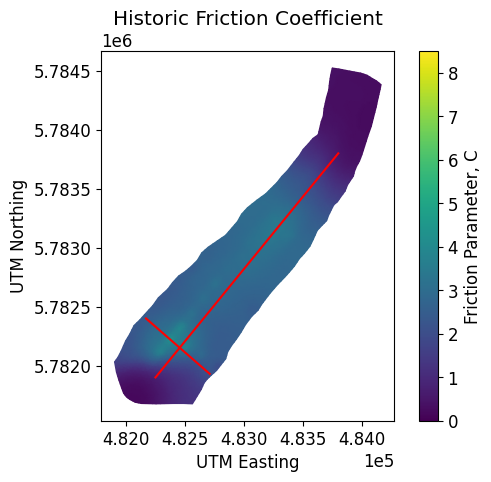

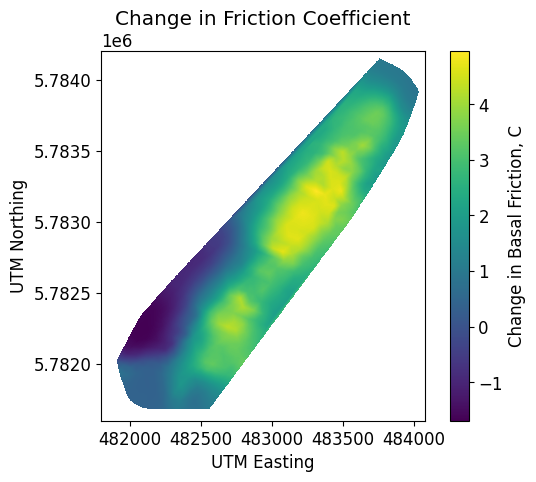

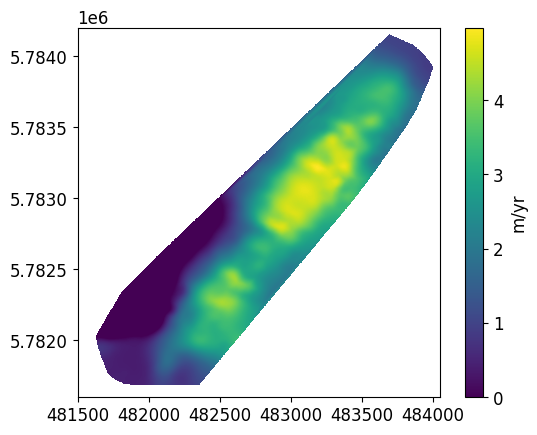

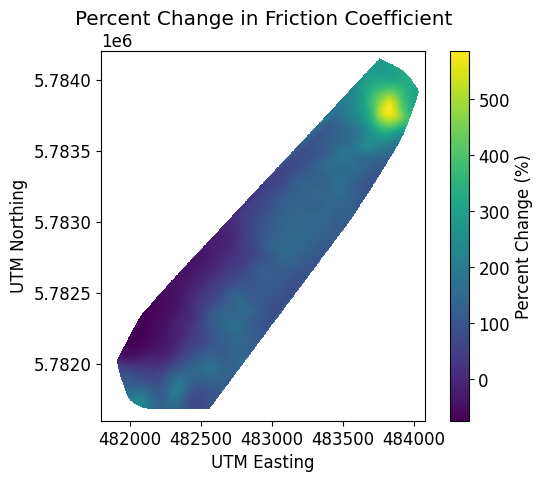

In [22]:
from scipy.interpolate import griddata


#uppermost corner coordinates (400 by 400 m square)
e1 = 4.82418e5
e2 = 4.82676e5
e3 = 4.82982e5
e4 = 4.82723e5


n1 = 5.782430e6
n2 = 5.782735e6
n3 = 5.782477e6
n4 = 5.782172e6

#side1
x1_box = np.linspace(e1,e2,100)
y1_box = np.linspace(n1,n2,100)

#side2
x2_box = np.linspace(e2,e3,100)
y2_box = np.linspace(n2,n3,100)

#side3
x3_box = np.linspace(e3,e4,100)
y3_box = np.linspace(n3,n4,100)

#side3
x3_box = np.linspace(e3,e4,100)
y3_box = np.linspace(n3,n4,100)

#side4
x4_box = np.linspace(e4,e1,100)
y4_box = np.linspace(n4,n1,100)



#long. profile
x = np.linspace(4.8225e5,4.838e5,100)
y = np.linspace(5.7819e6,5.7838e6,100)
#Raymond cross section
x2 = np.linspace(4.8217e5,4.8271e5,100)
y2 = np.linspace(5.7824e6,5.78193e6,100)

#convert back to friction parameter, C; from Beardmore script
#C = firedrake.interpolate(C_0 * firedrake.exp(θ), Q)
C = firedrake.interpolate(firedrake.exp(θ), Q)


#Upload sample points from smaller, modern mesh
points = np.loadtxt("ModernMeshSamplePoints.csv",
                 delimiter=",", dtype=float)

#Upload modern velocity solution at those points
Mod_C = np.loadtxt("ModernFriction.csv",
                 delimiter=",", dtype=float)

#extract data values as numpy array at those coordinates
Hist_C= np.array(C.at(points, tolerance=1e-10))

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(C,vmin= 0, vmax = 8.5,axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Friction Parameter, C"
)
axes.plot(x,y, color='red')
axes.plot(x2,y2, color='red')
axes.set_title('Historic Friction Coefficient');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure17.png',dpi=1500, facecolor='w', edgecolor='w',)


#Calculate differnence between modern
C_Change = Mod_C-Hist_C

#calculate %change in friction
percent_C = (C_Change/Hist_C)*100

print(np.max(percent_C))
print(np.min(percent_C))
print(np.median(percent_C))
print(np.mean(percent_C))

#get only the map view points for interpolant functions
points = points[:,:2]
print(points)

#Interpolate the change in velocity calculated at discrete points of the Historical and Modern Solution
#onto a grid for plotting
#using a scattered interpolant on defined grid 
grid_x, grid_y = np.meshgrid(np.linspace(4.818e5,4.8408e5,1000),
                             np.linspace(5.7842e6,5.7816e6,1000), indexing='ij')

grid_z1 = griddata(points, C_Change, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, C_Change, (grid_x, grid_y), method='cubic') 

fig, axes = plt.subplots()
colors=plt.imshow(grid_z1.T, extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6)) 
fig.colorbar(colors, label ='Change in Basal Friction, C')
axes.set_title('Change in Friction Coefficient');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure31.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = plt.subplots()
colors=plt.imshow(grid_z2.T, extent=(4.815e5,4.8405e5,5.7816e6,5.7842e6), vmin=0)
fig.colorbar(colors, label ='m/yr')

grid_z3 = griddata(points, percent_C, (grid_x, grid_y), method='linear')
#grid_z3 = griddata(points, percent_C, (grid_x, grid_y), method='cubic') 

fig, axes = plt.subplots()
colors=plt.imshow(grid_z3.T, extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6)) 
fig.colorbar(colors, label ='Percent Change (%)')
axes.set_title('Percent Change in Friction Coefficient');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure30.png',dpi=1500, facecolor='w', edgecolor='w',)

659
659
659
659
[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]
2.973574877889366
0.15301805095885576
15.182767324437027


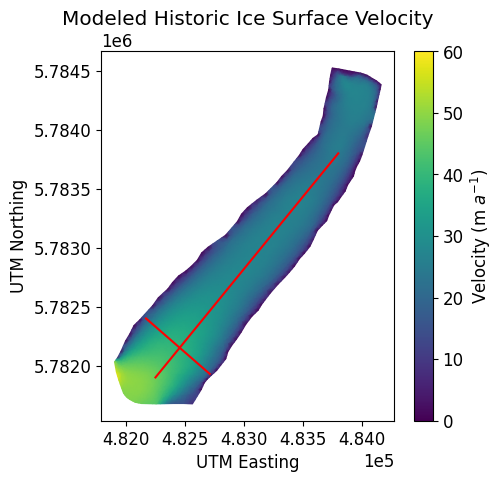

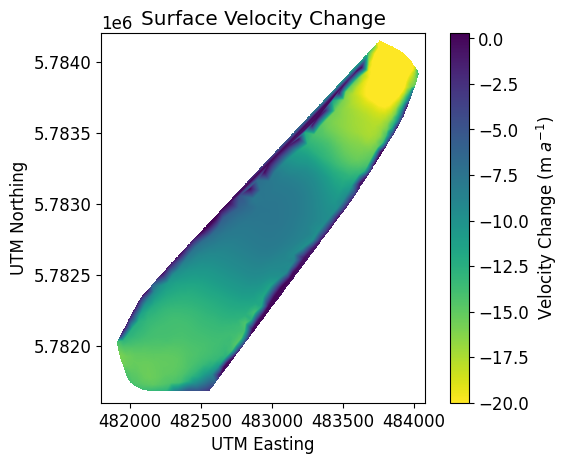

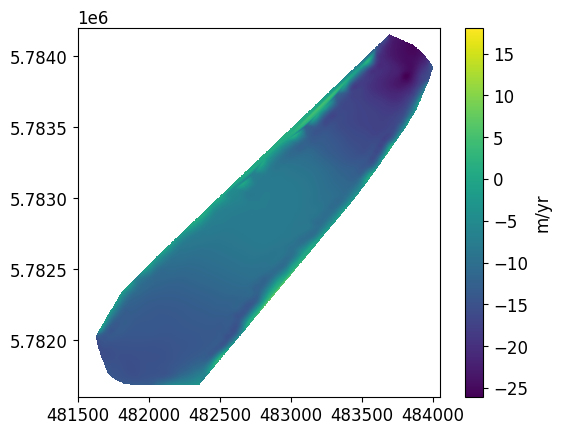

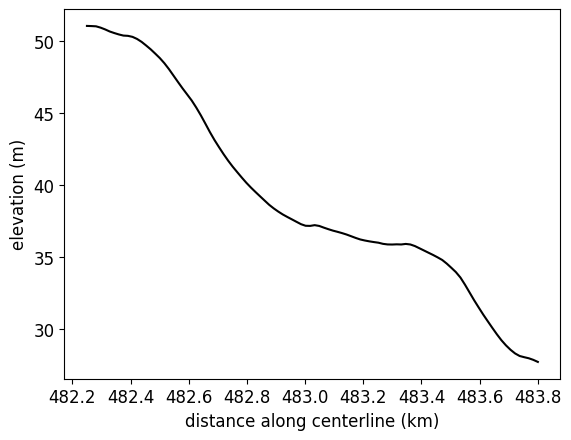

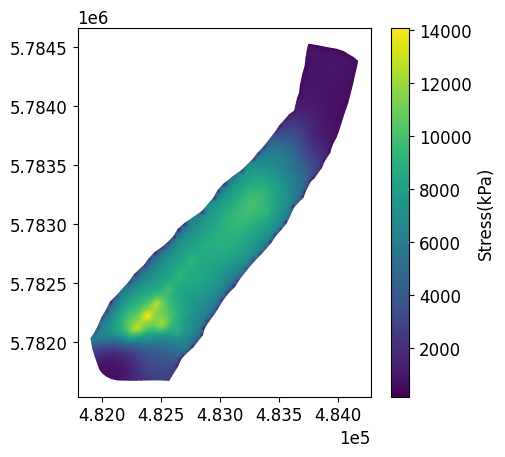

In [23]:
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

u_inverse = simulation(θ)


#be careful with double variable use!, x, y, z defined above in mesh coordinates
#for z, 1 is the surface and 0 is the bed
#set up centerline transect
x = np.linspace(4.8225e5,4.838e5,100)
y = np.linspace(5.7819e6,5.7838e6,100)
z = np.linspace(1,1,100)

#pair the x, y corrdinates into single array
xs = np.zeros((len(x), 3))
xs[:,0] = x
xs[:,1] = y
xs[:,2] = z

#Raymond cross section
x2 = np.linspace(4.8217e5,4.8271e5,100)
y2 = np.linspace(5.7824e6,5.78193e6,100)
z2 = np.linspace(1,1,100)

xs2 = np.zeros((len(x2), 3))
xs2[:,0] = x2
xs2[:,1] = y2
xs2[:,2] = z2

#Full model domain solution
x3 = np.linspace(4.80e5,4.845e5,1000)
y3 = np.linspace(5.7845e6,5.7815e6,1000)
z3 = np.linspace(1,1,1000)

#Upload sample points from smaller, modern mesh
points = np.loadtxt("ModernMeshSamplePoints.csv",
                 delimiter=",", dtype=float)

#Upload modern velocity solution at those points
ModVel = np.loadtxt("ModernSurfaceVelocity.csv",
                 delimiter=",", dtype=float)

print(len(points))


#extract data values as numpy array at those coordinates
Hist_Vel = np.array(u_inverse.at(points, tolerance=1e-10))
Hist_Vel_Mag = (((Hist_Vel[:,0])**2) + ((Hist_Vel[:,1])**2))**0.5

print(len(Hist_Vel))

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_inverse, vmin=0, vmax=60,axes=axes)
axes.plot(x,y, color='red')
axes.plot(x2,y2, color='red')
fig.colorbar(colors, label="Velocity (m $a^{-1}$)", ax=axes, fraction=.1, pad=0.04);
axes.set_title('Modeled Historic Ice Surface Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1500, facecolor='w', edgecolor='w',)

#Calculate differnence between modern
Vel_Change = ModVel-Hist_Vel_Mag


print(len(ModVel))
print(len(Vel_Change))

#get only the map view points for interpolant functions
points = points[:,:2]
print(points)

#Interpolate the change in velocity calculated at discrete points of the Historical and Modern Solution
#onto a grid for plotting
#using a scattered interpolant on defined grid 
grid_x, grid_y = np.meshgrid(np.linspace(4.818e5,4.8408e5,1000),
                             np.linspace(5.7842e6,5.7816e6,1000), indexing='ij')

grid_z1 = griddata(points, Vel_Change, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, Vel_Change, (grid_x, grid_y), method='cubic') 

fig, axes = plt.subplots()
colors=plt.imshow(grid_z1.T, extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6),vmin=-20, cmap='viridis_r') 
fig.colorbar(colors, label ='Velocity Change (m $a^{-1}$)')
axes.set_title('Surface Velocity Change');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure31.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, ax = plt.subplots()
colors=plt.imshow(grid_z2.T, extent=(4.815e5,4.8405e5,5.7816e6,5.7842e6))
fig.colorbar(colors, label ='m/yr')

    
#This is syntax to access modeled value for any grid point within the mesh domain
#check = s([4.8255e5,5.7825e6])
#print(check)

#stored as vx, vy in two columns
u_inv = np.array(u_inverse.at(xs, tolerance=1e-10))
#convert to velocity magnitude
#test = ((plot_shear[:,0])**2)
u_inv_mag = (((u_inv[:,0])**2) + ((u_inv[:,1])**2))**0.5
#hs = np.array(h.at(xs, tolerance=1e-10))
#bs = np.array(b.at(xs, tolerance=1e-10))
#us = np.array(u.at(xs, tolerance=1e-10))

u_inv2 = np.array(u_inverse.at(xs2, tolerance=1e-10))
#convert to velocity magnitude
#test = ((plot_shear[:,0])**2)
u_inv_mag2 = (((u_inv2[:,0])**2) + ((u_inv2[:,1])**2))**0.5

#Plot surface elevation and basal elevation along centerline transect
fig, axes = plt.subplots()
axes.plot(xs[:, 0] / 1e3, u_inv_mag, color='black')
#axes.plot(xs[:, 0] / 1e3, u_inv, color='blue')

axes.set_xlabel('distance along centerline (km)')
axes.set_ylabel('elevation (m)');


#calculate basal shear stress
expr = -1e3 * C * sqrt(inner(u_inverse, u_inverse)) ** (1 / m - 1) * u_inverse
τ_b = firedrake.interpolate(expr, V)
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ_b, axes=axes)
fig.colorbar(colors, label="Stress(kPa)", ax=axes, fraction=.1, pad=0.04);
#fig.colorbar(colors, label="kPa", fraction=0.012, pad=0.04);

#calculate model norm
def modnorm(θ):
    return inner(grad(θ), grad(θ)) * dx

#print model/data misfit and regularization for L-curve plots 140% landsat velocities; L=1000; T = 270.4K
print(assemble(loss_functional(u_inverse)))
print(assemble(regularization(θ)))
print(assemble(modnorm(θ)))

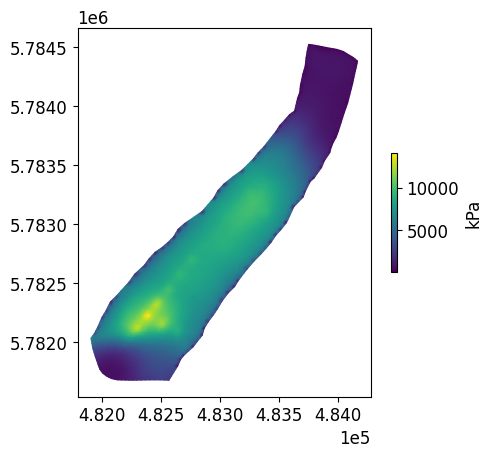

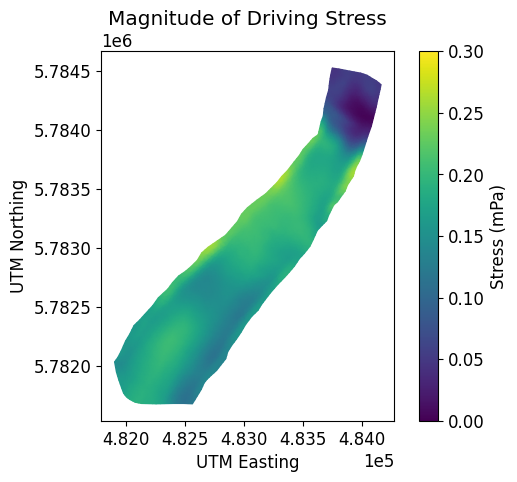

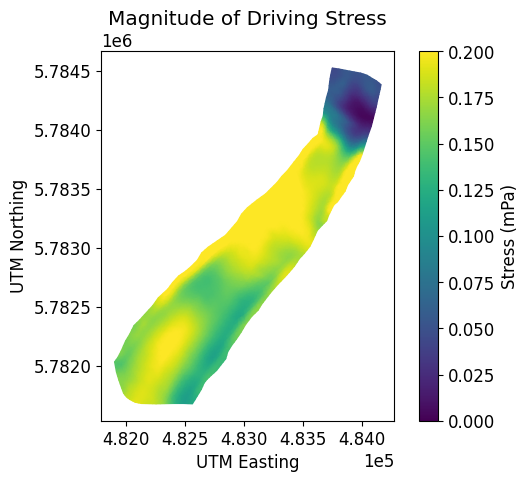

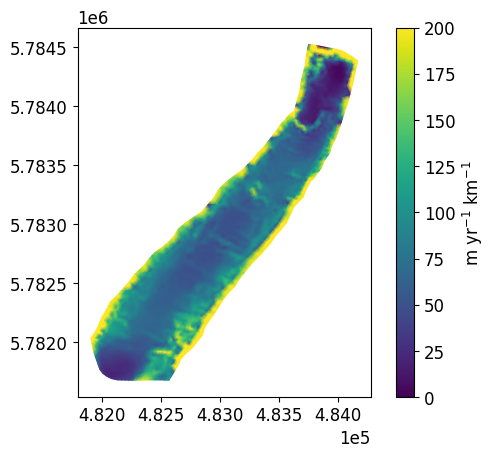

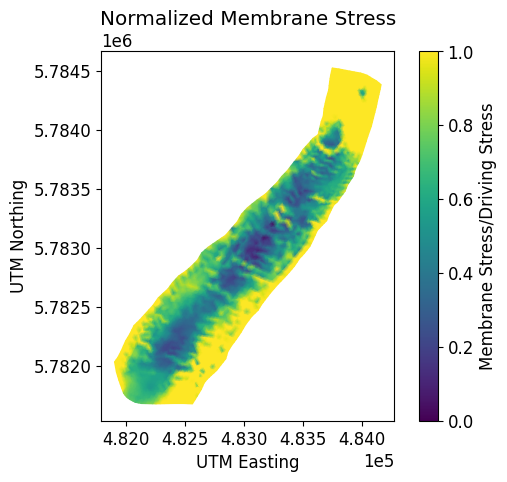

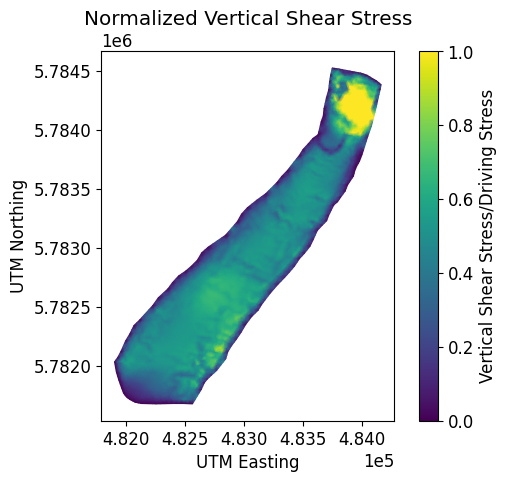

In [24]:
import sympy
from firedrake import inner, outer, sqrt, dx, ds_b, ds_v
from icepack.calculus import grad, sym_grad, trace, Identity, FacetNormal, get_mesh_axes
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    glen_flow_law as n,
    gravity as g,
    strain_rate_min,)


#make function from hybrid source code to calculate the strain rates and stresses
def horizontal_strain_rate(u, s, h):
    r"""Calculate the horizontal strain rate with corrections for terrain-
    following coordinates"""
    mesh = u.ufl_domain()
    dim = mesh.geometric_dimension()
    ζ = firedrake.SpatialCoordinate(mesh)[dim - 1]
    b = s - h
    v = -((1 - ζ) * grad(b) + ζ * grad(s)) / h
    du_dζ = u.dx(dim - 1)
    return sym_grad(u) + 0.5 * (outer(du_dζ, v) + outer(v, du_dζ))


def vertical_strain_rate(u, h):
    r"""Calculate the vertical strain rate with corrections for terrain-
    following coordinates"""
    mesh = u.ufl_domain()
    du_dζ = u.dx(mesh.geometric_dimension() - 1)
    return 0.5 * du_dζ / h

def _effective_strain_rate(ε_x, ε_z, ε_min):
    return sqrt((inner(ε_x, ε_x) + trace(ε_x) ** 2 + inner(ε_z, ε_z) + ε_min**2) / 2)

def membrane_stress(ε_x, ε_z, ε_e, A):
    r"""Calculate the membrane and vertical shear stresses for the given
    horizontal and shear strain rates and fluidity"""
    ε_min = firedrake.Constant(strain_rate_min)
    μ = 0.5 * A ** (-1 / n) * ε_e ** (1 / n - 1)
    I = Identity(ε_x.ufl_domain().geometric_dimension() - 1)
    return 2 * μ * (ε_x + trace(ε_x) * I)


def vertical_stress(ε_x, ε_z, ε_e, A):
    r"""Calculate the membrane and vertical shear stresses for the given
    horizontal and shear strain rates and fluidity"""
    ε_min = firedrake.Constant(strain_rate_min)
    μ = 0.5 * A ** (-1 / n) * ε_e ** (1 / n - 1)
    I = Identity(ε_x.ufl_domain().geometric_dimension() - 1)
    return 2 * μ * ε_z


def stress_mag(stress):
    return sqrt((inner(stress, stress)))

#variable order passed to function was incorrect!, fix!!!
ε_x_inv = horizontal_strain_rate(u_inverse, s_hist, h_hist)

ε_z_inv = vertical_strain_rate(u_inverse, h_hist)

ε_e_inv = _effective_strain_rate(ε_x_inv, ε_z_inv, strain_rate_min)

ε_e_inv_plot = firedrake.project(1e3*ε_e_inv, Q)

membrane_inv = membrane_stress(ε_x_inv, ε_z_inv, ε_e_inv, A)

shear_inv = vertical_stress(ε_x_inv, ε_z_inv, ε_e_inv, A)


#print(membrane_inv)

#type(membrane_inv)

#calculate the magnitude of stresses
membrane_inv_mag = stress_mag(membrane_inv)
shear_inv_mag = stress_mag(shear_inv)
driving_mag = stress_mag(τ)


#normalize membrane/vertical shear stress by magnitude of driving stress 
norm_membrane_inv = membrane_inv_mag/driving_mag
norm_shear_inv = shear_inv_mag/driving_mag

#project calculated stress solution back onto Function space, Q, for plotting in Icepack                 
norm_membrane_inv_plot = firedrake.project(norm_membrane_inv,Q)
norm_shear_inv_plot = firedrake.project(norm_shear_inv, Q)
driving_plot = firedrake.project(driving_mag,Q)
                

    
τ_b = firedrake.interpolate(expr, V)
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ_b, axes=axes)
fig.colorbar(colors, label="kPa", fraction=0.012, pad=0.04);


#driving stress
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ,vmin = 0, vmax =0.3, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Stress (mPa)"
)
axes.set_title('Magnitude of Driving Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1500, facecolor='w', edgecolor='w',)


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(driving_plot,vmin = 0, vmax =0.2, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Stress (mPa)"
)
axes.set_title('Magnitude of Driving Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1500, facecolor='w', edgecolor='w',)



fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(ε_e_inv_plot,vmin = 0, vmax =200, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="m yr${}^{-1}$ km${}^{-1}$"
)



fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(norm_membrane_inv_plot,vmin = 0, vmax =1, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Membrane Stress/Driving Stress"
)
axes.set_title('Normalized Membrane Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure17.png',dpi=1500, facecolor='w', edgecolor='w',)


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(norm_shear_inv_plot,vmin = 0, vmax =1, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Vertical Shear Stress/Driving Stress"
)
axes.set_title('Normalized Vertical Shear Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure18.png',dpi=1500, facecolor='w', edgecolor='w',)

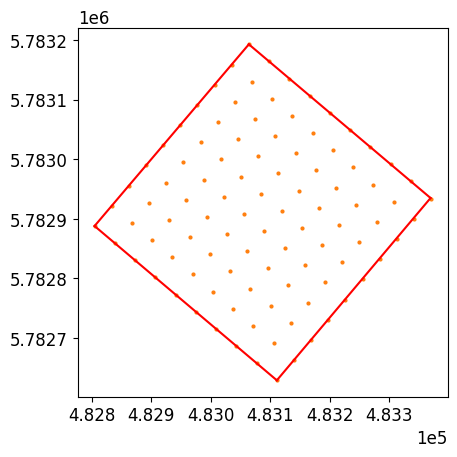

In [25]:
#uppermost corner coordinates (400 by 400 m square)
#e1 = 4.82418e5
#e2 = 4.82676e5
#e3 = 4.82982e5
#e4 = 4.82723e5


#n1 = 5.782430e6
#n2 = 5.782735e6
#n3 = 5.782477e6
#n4 = 5.782172e6

#200 m down glacier 
#e1 = 4.82547e5
#e2 = 4.82806e5
#e3 = 4.83111e5
#e4 = 4.82853e5


#n1 = 5.782582e6
#n2 = 5.782888e6
#n3 = 5.782629e6
#n4 = 5.782324e6

#200m down glacier 
#e1 = 4.82676e5
#e2 = 4.82935e5
#e3 = 4.83240e5
#e4 = 4.82982e5


#n1 = 5.782735e6
#n2 = 5.783040e6
#n3 = 5.782782e6
#n4 = 5.782477e6

#200m down glacier 
e1 = 4.82805e5
e2 = 4.83064e5
e3 = 4.83369e5
e4 = 4.83111e5


n1 = 5.782888e6
n2 = 5.783193e6
n3 = 5.782935e6
n4 = 5.782629e6

#lowest box
#e1 = 4.82935e5
#e2 = 4.83193e5
#e3 = 4.83489e5
#e4 = 4.83240e5


#n1 = 5.783041e6
#n2 = 5.783347e6
#n3 = 5.783088e6
#n4 = 5.782782e6



#side1
x1 = np.linspace(e1,e2,100)
y1 = np.linspace(n1,n2,100)

#side2
x2 = np.linspace(e2,e3,100)
y2 = np.linspace(n2,n3,100)

#side3
x3 = np.linspace(e3,e4,100)
y3 = np.linspace(n3,n4,100)

#side3
x3 = np.linspace(e3,e4,100)
y3 = np.linspace(n3,n4,100)

#side4
x4 = np.linspace(e4,e1,100)
y4 = np.linspace(n4,n1,100)


#sampling equations for driving stress
t = np.linspace(0,1,10)
s = np.linspace(0,1,10)

x_line =np.zeros(len(t)*len(s))
y_line =np.zeros(len(t)*len(s))

#formula of lines
for i in range(len(t)):
    for j in range(len(s)):
        x_line[j+(i*len(s))] = e1 + t[i]*(e4-e1) + s[j]*(e2-e1)
        y_line[j+(i*len(s))] = n1 + t[i]*(n4-n1) + s[j]*(n2-n1)
    


#print(x_line)
#print(y_line)

#np.vstack((tp, fp)).T
sample_points = np.vstack((x_line,y_line)).T


#print(test_points)



#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(sample_points[:,0], sample_points[:,1], 4.0, "tab:orange");
axes.plot(x1,y1, color='red')
axes.plot(x2,y2, color='red')
axes.plot(x3,y3, color='red')
axes.plot(x4,y4, color='red')

In [26]:

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, sample_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
sample_points2 = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
sample_points2 = np.append(sample_points2, np.ones([len(sample_points),1]), 1)
#print(sample_points)
print(len(sample_points2))


#sample driving stress at same points
τ_d_points = np.array(driving_plot.at(sample_points2, tolerance=1e-10))

print(τ_d_points)
mean_τ_d = np.mean(τ_d_points)

100
[0.16860274 0.17670789 0.18451603 0.19088496 0.1961951  0.20062253
 0.20453955 0.20778446 0.21023409 0.21105945 0.16919508 0.17673848
 0.18331274 0.1890218  0.19437474 0.19852071 0.20282532 0.20563387
 0.20697743 0.20710629 0.17161158 0.17864982 0.18362695 0.18997895
 0.19440165 0.19715416 0.20178056 0.20337149 0.20486806 0.20339639
 0.17262487 0.17895173 0.18448036 0.19038051 0.19404509 0.1972438
 0.20041075 0.20087202 0.20161345 0.20018671 0.17136887 0.17837214
 0.18462881 0.18970423 0.19377742 0.19657661 0.19788538 0.19714858
 0.19541572 0.19624793 0.16885515 0.1768555  0.18276768 0.18835739
 0.19042388 0.19225842 0.19260808 0.18986251 0.18708202 0.18688947
 0.16456233 0.17293227 0.1780736  0.18052244 0.18133387 0.18555855
 0.18535496 0.18341869 0.18099293 0.18103513 0.15652406 0.16298292
 0.17152589 0.1749807  0.1729511  0.17793042 0.17983226 0.178839
 0.17655436 0.17689939 0.14694036 0.15229805 0.15878878 0.16612964
 0.16673754 0.17022574 0.17322545 0.17476414 0.17174746 0.170

In [27]:
#membrane_inv is four-component tensor so need to interpolate each component individually
#R_xy and R_yx are symmetric/equal
R_xx = firedrake.interpolate(membrane_inv[0,0],Q)
R_xy = firedrake.interpolate(membrane_inv[1,0],Q)
R_yx = firedrake.interpolate(membrane_inv[0,1],Q)
R_yy = firedrake.interpolate(membrane_inv[1,1],Q)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[-0.01384741  0.07236502  0.07236502 -0.01326466]
 [-0.01155369  0.0727181   0.0727181  -0.0086796 ]
 [-0.00910728  0.0736678   0.0736678  -0.00375651]
 [-0.00650818  0.07521412  0.07521412  0.00150459]
 [-0.0037564   0.07735704  0.07735704  0.00710372]
 [-0.00065534  0.07915848  0.07915848  0.01351566]
 [ 0.00253046  0.07654958  0.07654958  0.02056423]
 [ 0.00407168  0.07397641  0.07397641  0.02440341]
 [ 0.00396832  0.07143896  0.07143896  0.02503321]
 [ 0.00222038  0.06893725  0.06893725  0.02245364]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[20.58174227 20.69976478 20.99070775 21.45517905 22.0939214  22.6460633
 21.95944984 21.26339741 20.55959945 19.84970406 19.135314   18.41798672
 17.69923431 16.98052352 16.2632758  15.54886722 15.58696317 16.00901416
 16.30683144 16.48105302 16.53238153 16.4

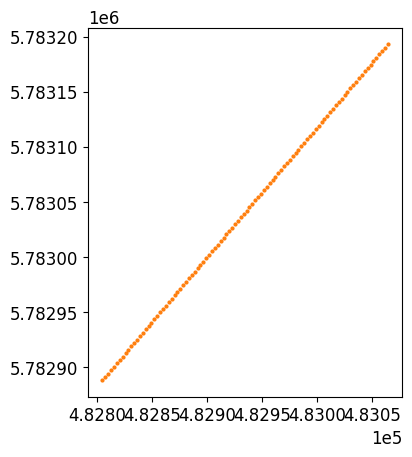

In [28]:

#side one solution 
side_one_points = np.vstack((x1,y1)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(side_one_points[:,0], side_one_points[:,1], 4.0, "tab:orange");

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_one_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_one_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_one_points = np.append(side_one_points, np.ones([len(side_one_points),1]), 1)

#sample along side 1 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_one_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_one_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_one_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_one_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h_hist.at(side_one_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 1
side1_sol = (h_points*rot_R[:,1])
print(side1_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side1_sol_mean = np.mean(side1_sol)
print(side1_sol_mean)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[-0.02512409 -0.07952698 -0.07952698 -0.04586733]
 [-0.01988438 -0.07939587 -0.07939587 -0.03627623]
 [-0.01389975 -0.07924996 -0.07924996 -0.02529084]
 [-0.00717022 -0.07908924 -0.07908924 -0.01291117]
 [ 0.00030424 -0.07891371 -0.07891371  0.00086279]
 [ 0.00827452 -0.07871851 -0.07871851  0.01567344]
 [ 0.01113789 -0.07830416 -0.07830416  0.02300547]
 [ 0.01340252 -0.0776769  -0.0776769   0.02890045]
 [ 0.01364209 -0.07756907 -0.07756907  0.03010599]
 [ 0.01181043 -0.07820578 -0.07820578  0.02657445]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[-15.4367683  -15.54867211 -15.6610518  -15.77380706 -15.88683326
 -15.98501139 -15.74506465 -15.45283789 -15.31005718 -15.38507082
 -15.43999033 -15.47518185 -15.49093544 -15.48746509 -15.46490867
 -15.42332801 -15.36270881 -15.28296073 -15.18391732 -15.0653

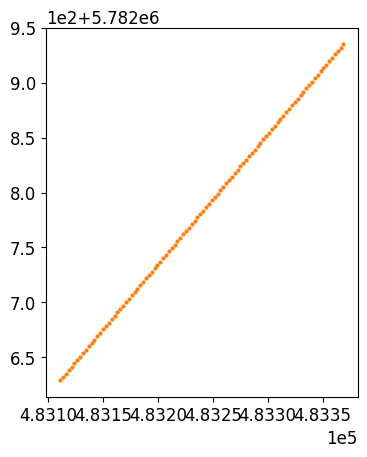

In [29]:
#side 3 solution 
side_three_points = np.vstack((x3,y3)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(side_three_points[:,0], side_three_points[:,1], 4.0, "tab:orange");

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_three_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_three_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_three_points = np.append(side_three_points, np.ones([len(side_three_points),1]), 1)

#sample along side 1 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_three_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_three_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_three_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_three_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h_hist.at(side_three_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 1
side3_sol = (h_points*rot_R[:,1])
print(side3_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side3_sol_mean = np.mean(side3_sol)
print(side3_sol_mean)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[ 0.00699401  0.07561981  0.07561981 -0.0066295 ]
 [ 0.00905796  0.07334371  0.07334371 -0.00628795]
 [ 0.00675064  0.0716302   0.0716302  -0.01015271]
 [ 0.00486346  0.06993904  0.06993904 -0.01311938]
 [ 0.00339642  0.06827026  0.06827026 -0.01518794]
 [ 0.00234952  0.06662384  0.06662384 -0.01635839]
 [ 0.00172275  0.06499978  0.06499978 -0.01663074]
 [ 0.00151612  0.06339809  0.06339809 -0.01600499]
 [ 0.00172962  0.06181877  0.06181877 -0.01448113]
 [ 0.00236326  0.06026181  0.06026181 -0.01205917]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[ 1.66643519  2.17622564  1.63077661  1.18134777  0.82955124  0.57702716
  0.42544368  0.37649695  0.43191113  0.59343839  0.86285888  1.16025567
  1.40746598  1.65800705  1.91161069  2.16800482  2.56795981  3.12653598
  3.62679922  4.06709469  4.44593151  4.

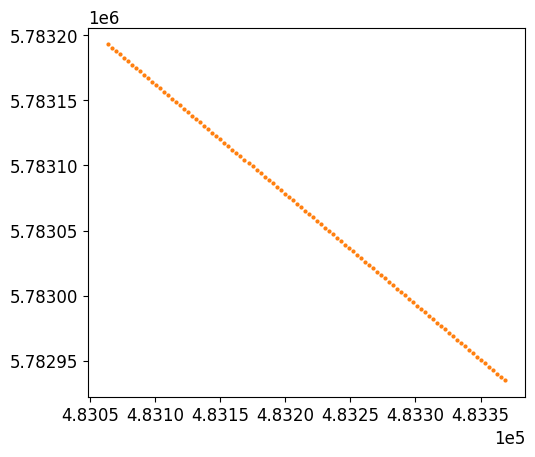

In [30]:
#side 2 solution 
side_two_points = np.vstack((x2,y2)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(side_two_points[:,0], side_two_points[:,1], 4.0, "tab:orange");


#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_two_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_two_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_two_points = np.append(side_two_points, np.ones([len(side_two_points),1]), 1)

#sample along side 2 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_two_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_two_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_two_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_two_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h_hist.at(side_two_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 2
side2_sol = (h_points*rot_R[:,0])
print(side2_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side2_sol_mean = np.mean(side2_sol)
print(side2_sol_mean)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[ 0.013396   -0.07868068 -0.07868068  0.02881988]
 [ 0.00902111 -0.07563012 -0.07563012  0.01854219]
 [ 0.00475195 -0.07309386 -0.07309386  0.00896683]
 [ 0.00216977 -0.07297659 -0.07297659  0.00455767]
 [-0.00027719 -0.0727376  -0.0727376   0.0003089 ]
 [-0.00258895 -0.0723769  -0.0723769  -0.00377947]
 [-0.00476549 -0.07189449 -0.07189449 -0.00770744]
 [-0.00680682 -0.07129036 -0.07129036 -0.01147502]
 [-0.00871294 -0.07056452 -0.07056452 -0.0150822 ]
 [-0.01048385 -0.06971696 -0.06971696 -0.01852898]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[ 2.68800388  1.83947066  0.98333285  0.45272344 -0.05831426 -0.5491365
 -1.01909336 -1.46752871 -1.89378021 -2.29717935 -1.64714573 -1.01486809
 -0.48676283 -0.06660381  0.24196725  0.43544079  0.51043938  0.22301292
 -0.27937578 -0.67705274 -0.96656139 -1.1

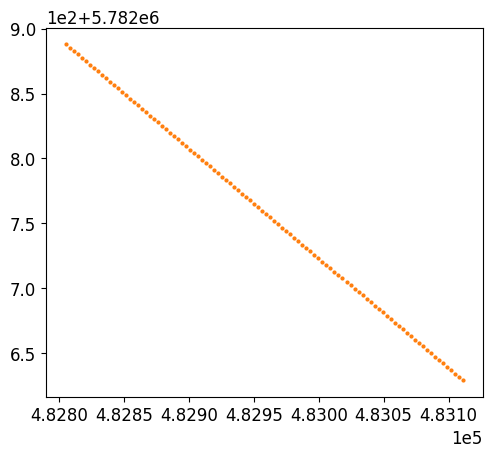

In [31]:
#side 4 solution 
side_four_points = np.vstack((x4,y4)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(side_four_points[:,0], side_four_points[:,1], 4.0, "tab:orange");


#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_four_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_four_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_four_points = np.append(side_four_points, np.ones([len(side_four_points),1]), 1)

#sample along side 2 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_four_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_four_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_four_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_four_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h_hist.at(side_four_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 1
side4_sol = (h_points*rot_R[:,0])
print(side4_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side4_sol_mean = np.mean(side4_sol)
print(side4_sol_mean)

In [32]:
f_lon = (side2_sol_mean-side4_sol_mean)/400
print(f_lon)

f_lat = (side3_sol_mean-side1_sol_mean)/400
print(f_lat)

print(mean_τ_d)

t_base = mean_τ_d + f_lon + f_lat

print(t_base)

#calculate percent change from modern results

f_lon_percent = (0.00276-f_lon)/f_lon*100
print(f_lon_percent)

f_lat_percent = (-0.04155-f_lat)/f_lat*100
print(f_lat_percent)

drive_percent = (0.11981-mean_τ_d)/mean_τ_d*100
print(drive_percent)

base_percent = (0.08103-t_base)/t_base*100
print(base_percent)

-0.0019797481314266425
-0.07816525898075846
0.18250497323525564
0.10235996612307052
-239.41167344409075
-46.84339239478737
-34.35247386625432
-20.83819185464056


In [33]:
#create regularly sampled grid of UTM coordinates over model domain: SET HERE DJP
E_min = 4.817e5
E_max = 4.842e5
N_min = 5.7815e6
N_max = 5.7847e6
xi = np.linspace(E_min,E_max,25)
yi = np.linspace(N_min,N_max,25)
X,Y = np.meshgrid(xi,yi)

p_2d = np.array([(x,y) for x in xi for y in yi])
p_3d = np.array([(x,y,1) for x in xi for y in yi])

print(p_3d)
print(len(p_3d))

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, p_2d, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
sample_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
sample_points = np.append(sample_points, np.ones([len(sample_points),1]), 1)
print(sample_points)
print(len(sample_points))


#membrane_inv is four-component tensor so need to interpolate each component individually
#R_xy and R_yx are symmetric/equal
R_xx = firedrake.interpolate(membrane_inv[0,0],Q)
R_xy = firedrake.interpolate(membrane_inv[1,0],Q)
R_yx = firedrake.interpolate(membrane_inv[0,1],Q)
R_yy = firedrake.interpolate(membrane_inv[1,1],Q)

#sample at discrete points in the mesh
R_xx_points = np.array(R_xx.at(sample_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(sample_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(sample_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(sample_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h_hist.at(sample_points, tolerance=1e-10))

#sample driving stress at same points
τ_d_points = np.array(driving_plot.at(sample_points, tolerance=1e-10))

[[4.81700000e+05 5.78150000e+06 1.00000000e+00]
 [4.81700000e+05 5.78163333e+06 1.00000000e+00]
 [4.81700000e+05 5.78176667e+06 1.00000000e+00]
 ...
 [4.84200000e+05 5.78443333e+06 1.00000000e+00]
 [4.84200000e+05 5.78456667e+06 1.00000000e+00]
 [4.84200000e+05 5.78470000e+06 1.00000000e+00]]
625
[[4.81908333e+05 5.78203333e+06 1.00000000e+00]
 [4.82012500e+05 5.78176667e+06 1.00000000e+00]
 [4.82012500e+05 5.78190000e+06 1.00000000e+00]
 [4.82012500e+05 5.78203333e+06 1.00000000e+00]
 [4.82012500e+05 5.78216667e+06 1.00000000e+00]
 [4.82116667e+05 5.78176667e+06 1.00000000e+00]
 [4.82116667e+05 5.78190000e+06 1.00000000e+00]
 [4.82116667e+05 5.78203333e+06 1.00000000e+00]
 [4.82116667e+05 5.78216667e+06 1.00000000e+00]
 [4.82116667e+05 5.78230000e+06 1.00000000e+00]
 [4.82220833e+05 5.78176667e+06 1.00000000e+00]
 [4.82220833e+05 5.78190000e+06 1.00000000e+00]
 [4.82220833e+05 5.78203333e+06 1.00000000e+00]
 [4.82220833e+05 5.78216667e+06 1.00000000e+00]
 [4.82220833e+05 5.78230000e+0

/Users/davidpolashenski/firedrake/src/firedrake/firedrake/mesh.py:2415: UserWarning: 482 vertices are outside the mesh and have been removed from the VertexOnlyMesh
  warn(msg)


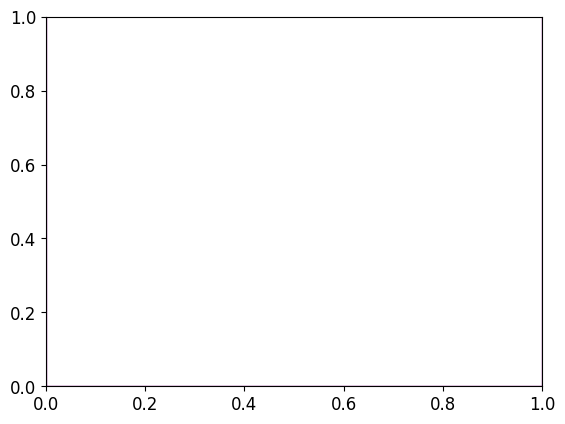

In [34]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
square = patches.Rectangle((0, 0), 1, 2, edgecolor='purple', facecolor='none')
ax.add_patch(square)




In [35]:
#theta = np.sin(45.*np.pi/180)

theta = [45.*np.pi/180]

theta1 = np.cos(theta)
theta2 = np.sin(theta)*-1
theta3 = np.sin(theta)
theta4 = np.cos(theta)

#print(theta3)

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xx_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)



[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(143, 4)
[[-0.01708819  0.07476893  0.07476893 -0.17836668]
 [ 0.05573805  0.0023151   0.0023151   0.12093556]
 [-0.00547522  0.02979312  0.02979312  0.01952247]
 [-0.05321423  0.06218362  0.06218362 -0.08771103]
 [-0.01942652  0.13799236  0.13799236 -0.01393745]
 [ 0.06363582  0.00485669  0.00485669  0.11553886]
 [ 0.03629446  0.01658732  0.01658732  0.07753934]
 [ 0.0417616   0.05142072  0.05142072  0.01976425]
 [ 0.01364914  0.08146532  0.08146532  0.01795667]
 [-0.01906309  0.10194459  0.10194459  0.04879213]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]


In [36]:
#determine the indices of in p_3d where sample points (R_xx, etc inside model domain) are pulled from
ind=[]
for elements in list(map(tuple,sample_points)):
    ind.append(list(map(tuple,p_3d)).index(elements))

#print(ind)
print(len(ind))

#print(p_3d[ind,:])

143


In [37]:
print(R_xx_points[0:9])
print(rot_R[0:9,:])

#make a placeholder matrix that is the size you want it to be for later calculations
#holder = np.zeros(len(p_3d))
R_xx_rot = np.zeros(len(p_3d))
R_xy_rot = np.zeros(len(p_3d))
R_yx_rot = np.zeros(len(p_3d))
R_yy_rot = np.zeros(len(p_3d))
H_samples = np.zeros(len(p_3d))
τ_d_samples = np.zeros(len(p_3d))

#print(holder)
#print(len(holder))

#use np.put to place the R_xx_points at specific indices determined from above; DON'T SET EQUAL TO NEW VARIABLE
#RETURNS NONE INSTEAD OF VALUES PLACED CORRECTLY
#np.put(holder, ind, R_xx_points)
np.put(R_xx_rot, ind, rot_R[:,0])
np.put(R_xy_rot, ind, rot_R[:,1])
np.put(R_yx_rot, ind, rot_R[:,2])
np.put(R_yy_rot, ind, rot_R[:,3])
np.put(H_samples, ind, h_points)
np.put(τ_d_samples, ind, τ_d_points)

#print(holder)
#print(len(holder))

#reshape the stress values to correct places on sample coordinates from above to allow for differentiation
R_xx_grid = R_xx_rot.reshape(25,25)
R_xy_grid = R_xy_rot.reshape(25,25)
R_yx_grid = R_yx_rot.reshape(25,25)
R_yy_grid = R_yy_rot.reshape(25,25)
H_grid = H_samples.reshape(25,25)
τ_d_grid = τ_d_samples.reshape(25,25)

#can look at a single row/column to make sure makes sense with indices above (appears to)
print(H_grid[8,:])
print(τ_d_grid[8,:])



[-0.0229585   0.0906519   0.03681675 -0.00827901  0.12131037  0.09444403
  0.07350421  0.08218365  0.09726823]
[[-0.01708819  0.07476893  0.07476893 -0.17836668]
 [ 0.05573805  0.0023151   0.0023151   0.12093556]
 [-0.00547522  0.02979312  0.02979312  0.01952247]
 [-0.05321423  0.06218362  0.06218362 -0.08771103]
 [-0.01942652  0.13799236  0.13799236 -0.01393745]
 [ 0.06363582  0.00485669  0.00485669  0.11553886]
 [ 0.03629446  0.01658732  0.01658732  0.07753934]
 [ 0.0417616   0.05142072  0.05142072  0.01976425]
 [ 0.01364914  0.08146532  0.08146532  0.01795667]]
[  0.           0.         185.47082859 218.40806526 288.70776928
 307.62408721 319.77456114 314.11023977 301.73354713 260.6717412
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
[0.         0.         0.11387174 0.13450032 0.15952904 0.17838861
 0.19147092 0.18000227 0.15539893 0.15607286 0. 

In [38]:
xi = np.linspace(E_min,E_max,25)
yi = np.linspace(N_min,N_max,25)
grid_points = np.array([(x,y) for x in xi for y in yi])

#determine the grid cell sizes
del_x = (E_max-E_min)/25
del_y = (N_max-N_min)/25

print(del_x)
print(del_y)

#initalize array to hold longitudinal and lateral forces calculated in for loop 
s=(25,25)
F_lon = np.zeros(s)
F_lat = np.zeros(s)
τ_base = np.zeros(s)

#print(τ_d_grid[10,:])

#create loop to calculate the longitudinal force
for i in range(1,24):
    for j in range(0,25):
        F_lon[i,j] = ((H_grid[i+1,j]*R_xx_grid[i+1,j])-(H_grid[i-1,j]*R_xx_grid[i-1,j]))/(2*del_x)
        
#print(F_lon[10,:])


#create loop to calculate the lateral force
for i in range(0,25):
    for j in range(1,24):
        F_lat[i,j] = ((H_grid[i,j+1]*R_xy_grid[i,j+1])-(H_grid[i,j-1]*R_xy_grid[i,j-1]))/(2*del_y)
        
#print(F_lat[10,:])

#loop to calculate basal shear stress
for i in range(0,25):
    for j in range(0,25):
        τ_base[i,j] = ((τ_d_grid[i,j])+(F_lon[i,j])+(F_lat[i,j]))

print(τ_base[8,:])

100.0
128.0
[ 0.         -0.06907348  0.01089943  0.15746202  0.16243559  0.1158886
  0.2296912   0.2866971   0.2666366   0.05692335 -0.11363535  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


659
659
[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]
[-0.03613227 -0.03432781 -0.03520024 -0.03648914 -0.0366164  -0.0341906
 -0.0334259  -0.03646015 -0.03392444 -0.03324341 -0.03624688 -0.03592937
 -0.03591021 -0.03168387 -0.0363479  -0.03608638 -0.03194824 -0.03514909
 -0.03739158 -0.03720531 -0.0362391  -0.03289853 -0.03589966 -0.03402218
 -0.03343422 -0.03097146 -0.03590754 -0.03206395 -0.03000848 -0.03028019
 -0.03482992 -0.03247322 -0.03321384 -0.03572404 -0.03531655 -0.03407984
 -0.03029669 -0.03077959 -0.0347782  -0.03263247 -0.03244891 -0.03499777
 -0.02946827 -0.03842562 -0.03587469 -0.03356947 -0.03206779 -0.0321625
 -0.03474306 -0.0345938  -0.03223855 -0.0305948  -0.03022115 -0.035105
 -0.033942   -0.03236733 -0.03447768 -0.03534068 -0.03973259 -0.03604244
 -0.0361134  -0.0327181  -0.03151468 -

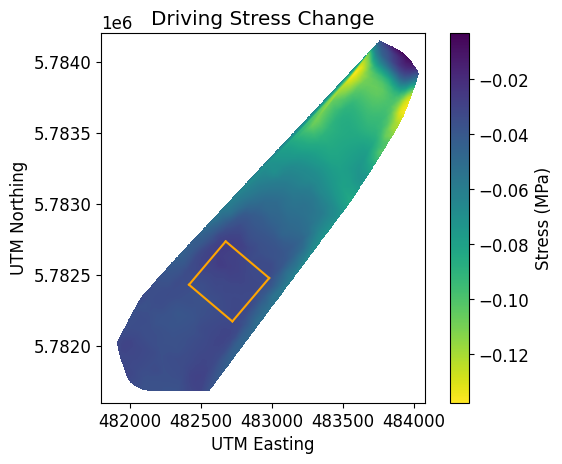

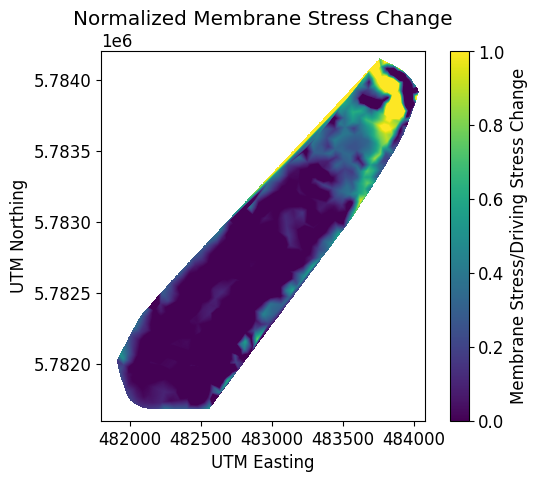

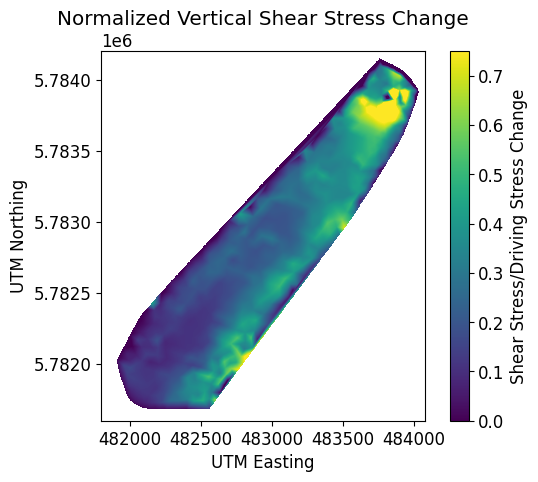

In [40]:
#Upload modern driving stress solution at those points
ModDriveStress = np.loadtxt("ModernDrivingStress.csv",
                 delimiter=",", dtype=float)

#Upload sample points from smaller, modern mesh
points = np.loadtxt("ModernMeshSamplePoints.csv",
                 delimiter=",", dtype=float)

#extract historical data values as numpy array at those coordinates from Modern mesh
Hist_Drive = np.array(driving_plot.at(points, tolerance=1e-10))


#Calculate differnence between modern
Drive_Change = ModDriveStress-Hist_Drive

#Upload modern membrane stress solution at those points
ModMembraneStress = np.loadtxt("ModernMembraneStress.csv",
                 delimiter=",", dtype=float)

#Upload sample points from smaller, modern mesh
points = np.loadtxt("ModernMeshSamplePoints.csv",
                 delimiter=",", dtype=float)

#extract data values as numpy array at those coordinates
Hist_Membrane = np.array(norm_membrane_inv_plot.at(points, tolerance=1e-10))


#Calculate differnence between modern
Membrane_Change = ModMembraneStress-Hist_Membrane


#Upload modern membrane stress solution at those points
ModShearStress = np.loadtxt("ModernShearStress.csv",
                 delimiter=",", dtype=float)

#Upload sample points from smaller, modern mesh
points = np.loadtxt("ModernMeshSamplePoints.csv",
                 delimiter=",", dtype=float)

#extract data values as numpy array at those coordinates
Hist_Shear = np.array(norm_shear_inv_plot.at(points, tolerance=1e-10))


#Calculate differnence between modern
Shear_Change = ModShearStress-Hist_Shear


print(len(ModVel))
print(len(Vel_Change))

#get only the map view points for interpolant functions
points = points[:,:2]
print(points)
print(Drive_Change)

#Interpolate the change in velocity calculated at discrete points of the Historical and Modern Solution
#onto a grid for plotting
#using a scattered interpolant on defined grid 
grid_x, grid_y = np.meshgrid(np.linspace(4.818e5,4.8408e5,1000),
                             np.linspace(5.7842e6,5.7816e6,1000), indexing='ij')

grid_z1 = griddata(points, Drive_Change, (grid_x, grid_y), method='linear')

grid_mem = griddata(points, Membrane_Change, (grid_x, grid_y), method='linear')

grid_shear = griddata(points, Shear_Change, (grid_x, grid_y), method='linear')

print(np.max(Drive_Change))
print(np.min(Drive_Change))
print(np.median(Drive_Change))
print(np.mean(Drive_Change))

fig, axes = plt.subplots()
colors=plt.imshow(grid_z1.T, extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6),cmap='viridis_r') 
fig.colorbar(colors, label ='Stress (MPa)')
axes.set_title('Driving Stress Change');
axes.plot(x1_box,y1_box, color='orange')
axes.plot(x2_box,y2_box, color='orange')
axes.plot(x3_box,y3_box, color='orange')
axes.plot(x4_box,y4_box, color='orange')
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure31.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = plt.subplots()
colors=plt.imshow(grid_mem.T, extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6),vmin=0,vmax=1) 
fig.colorbar(colors, label ='Membrane Stress/Driving Stress Change')
axes.set_title('Normalized Membrane Stress Change');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure32.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = plt.subplots()
colors=plt.imshow(grid_shear.T, extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6),vmin=0,vmax=0.75) 
fig.colorbar(colors, label ='Shear Stress/Driving Stress Change')
axes.set_title('Normalized Vertical Shear Stress Change');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure33.png',dpi=1500, facecolor='w', edgecolor='w',)


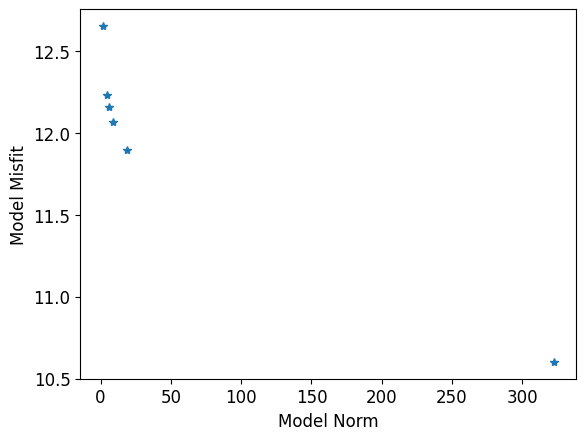

In [41]:
#plot L-curve for L = 1000, 500, 100, 50, and 10 

#model_misfit = [11.36, 11.06185, 9.80735, 9.57773, 8.92305]

#model_norm = [1.80, 3.96442, 235.19264, 1143.07031, 4701.16447]

#12-05-2023 L-Curve for L = 1000, 500, 400, 300, 200, 100
model_misfit = [12.65177, 12.22729, 12.15481, 12.06398, 11.894145, 10.601305 ]
model_norm = [1.61799, 4.38276, 5.87557, 8.96553, 18.81358,322.31029 ]

#plt.loglog(model_norm, model_misfit, '*')

fig, axes = plt.subplots()
axes.plot(model_norm, model_misfit, '*')
axes.set_xlabel('Model Norm')
axes.set_ylabel('Model Misfit');

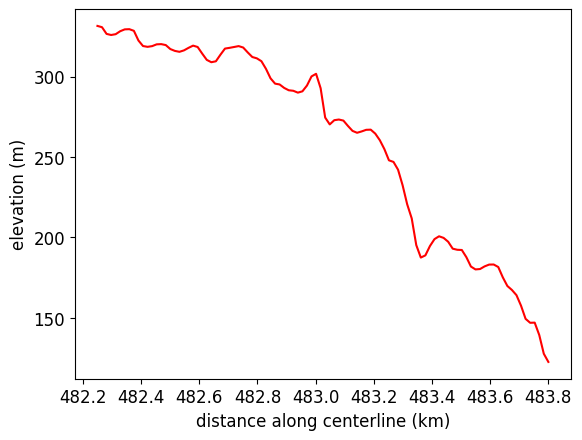

In [42]:
hs = np.array(h_hist.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0] / 1e3, hs, color='red')
axes.set_xlabel('distance along centerline (km)')
axes.set_ylabel('elevation (m)');

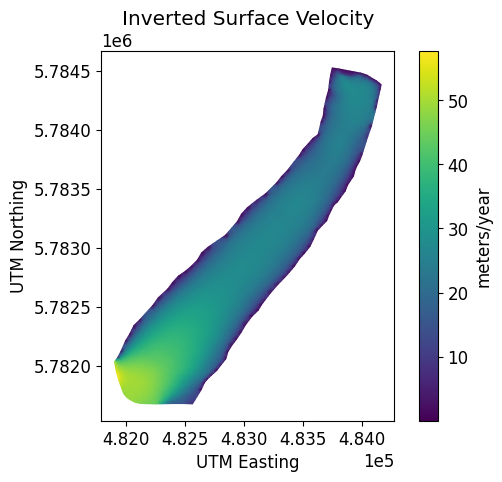

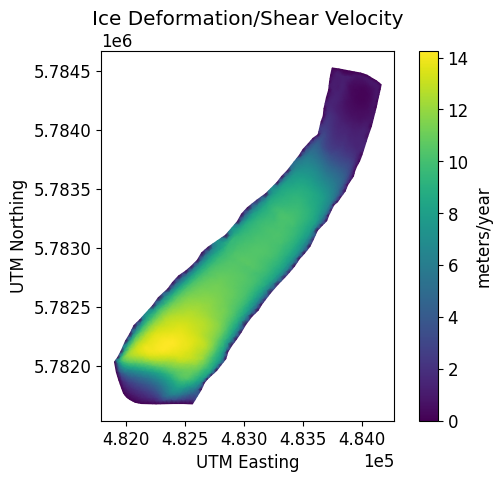

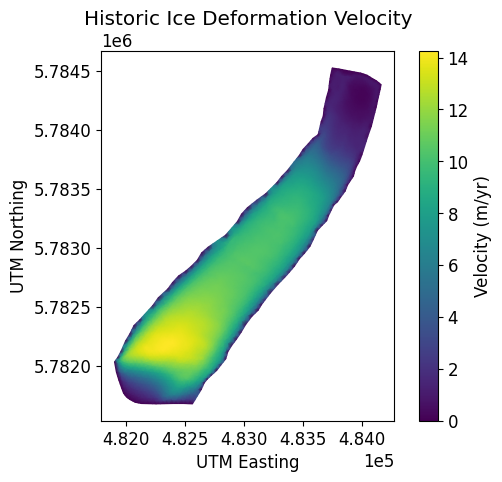

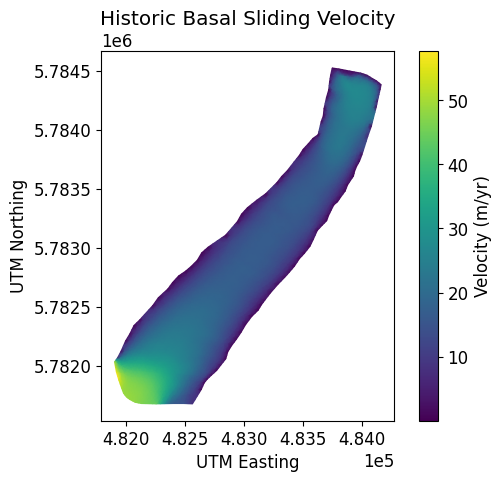

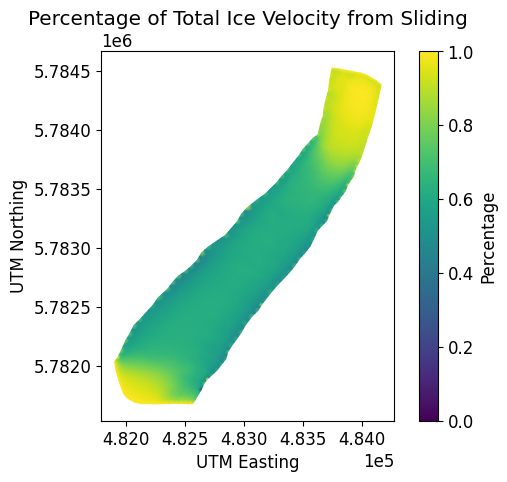

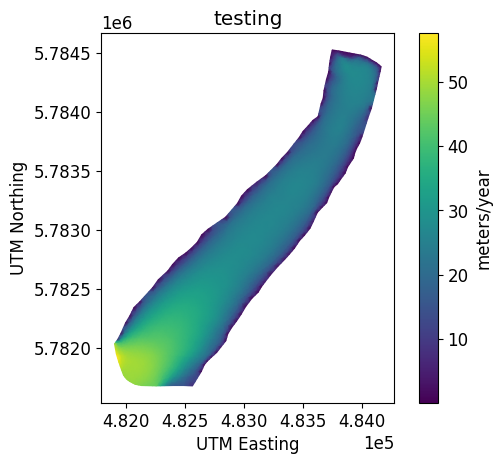

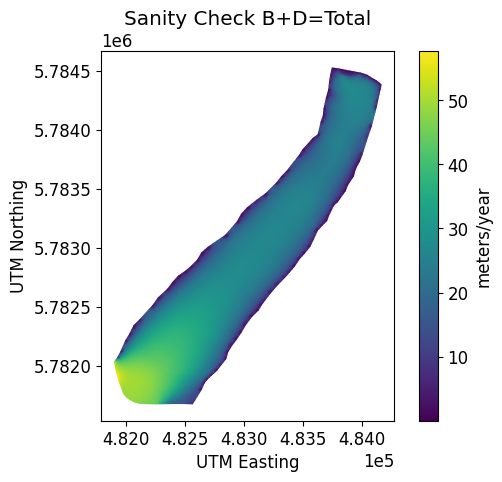

In [43]:
u_shear = icepack.depth_average(u_inverse, weight=np.sqrt(3) * (2 * ζ - 1))

u_shear.ufl_domain() is mesh2d
#u_shear.ufl_domain() is mesh

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_inverse, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Inverted Surface Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1500, facecolor='w', edgecolor='w',)


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_shear, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Ice Deformation/Shear Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure21.png',dpi=1500, facecolor='w', edgecolor='w',)

#u_inverse_mag = (((u_inverse[:,0])**2) + ((u_inverse[:,1])**2))**0.5

from firedrake import inner, sqrt


#calculate shear and plug flow velocity components and ratio
u_avg = icepack.depth_average(u_inverse)

Q2D = firedrake.FunctionSpace(mesh2d, "CG", 2)
U_shear = sqrt(inner(u_shear, u_shear))
U_avg = sqrt(inner(u_avg, u_avg))
U_base = U_avg-U_shear
ratio = U_base/U_avg

U_shear_plot = firedrake.interpolate(U_shear, Q2D)
U_avg_plot = firedrake.interpolate(U_avg, Q2D)
U_base_plot = firedrake.interpolate(U_base,Q2D)
#Ratio of total velocity that is basal sliding
ratio_plot = firedrake.interpolate(U_base/U_avg, Q2D)


#ratio = firedrake.interpolate(U_shear / U_avg, u_avg.function_space())

# #u_base.ufl_domain() is mesh2d

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_shear_plot, axes=axes)
fig.colorbar(colors, orientation="vertical", label="Velocity (m/yr)");
axes.set_title('Historic Ice Deformation Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure22.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_base_plot, axes=axes)
fig.colorbar(colors, orientation="vertical", label="Velocity (m/yr)");
axes.set_title('Historic Basal Sliding Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure23.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(ratio_plot, vmin = 0, vmax =1,axes=axes)
fig.colorbar(colors, orientation="vertical", label="Percentage");
axes.set_title('Percentage of Total Ice Velocity from Sliding');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure24.png',dpi=1500, facecolor='w', edgecolor='w',)

basal= u_inverse*ratio

#basal_plot= firedrake.interpolate(basal, Q2D)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_avg_plot, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('testing');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure25.png',dpi=1500, facecolor='w', edgecolor='w',)



u_check = U_shear+U_base
u_check_plot = firedrake.interpolate(u_check, Q2D)
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_check_plot, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Sanity Check B+D=Total');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure26.png',dpi=1500, facecolor='w', edgecolor='w',)





In [44]:
#Upload sample points from smaller, modern mesh
points = np.loadtxt("ModernMeshSamplePoints.csv",
                 delimiter=",", dtype=float)

points = points[:,:2]
print(points)

[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]


[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]
10.32827119951217
-2.3877148378756736
0.5062557053489916
0.590572249604563
659
659
[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]


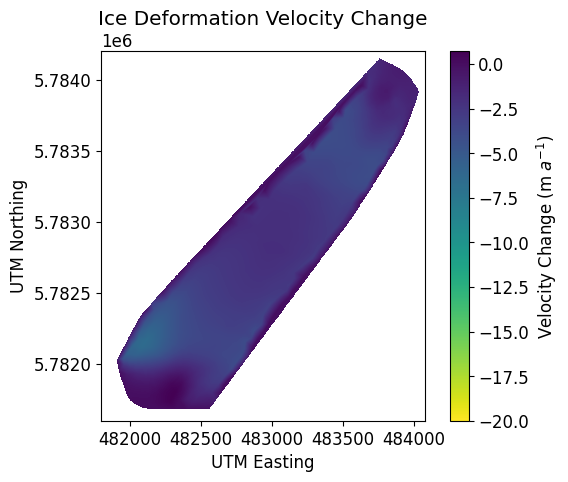

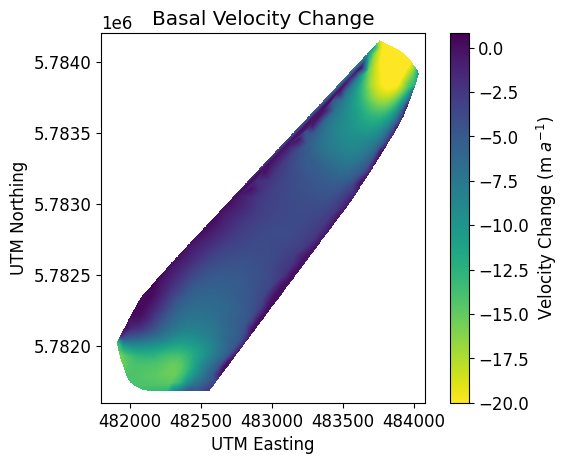

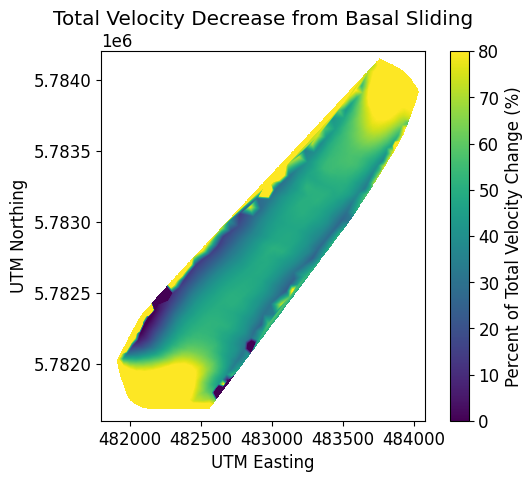

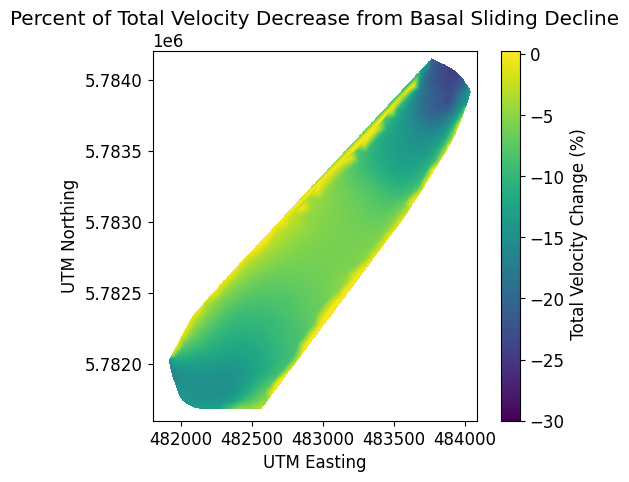

In [45]:
#Upload sample points from smaller, modern mesh
points = np.loadtxt("ModernMeshSamplePoints.csv",
                 delimiter=",", dtype=float)

points = points[:,:2]
print(points)

#Upload modern deformation velocity solution at those points
ModDefVel = np.loadtxt("ModernDeformationVelocity.csv",
                 delimiter=",", dtype=float)

ModBaseVel = np.loadtxt("ModernBasalVelocity.csv",
                 delimiter=",", dtype=float)

ModRatioVel = np.loadtxt("ModernRatioVelocity.csv",
                 delimiter=",", dtype=float)

#extract data values as numpy array at those coordinates
#If it claims a point is not in the mesh domain (but should be), try increasing the tolerance value so that it
#finds the nearest point in the mesh; not necessarily outside the perimeter/glacier boundary
HistDefVel = np.array(U_shear_plot.at(points, tolerance=1e-6))
HistBaseVel = np.array(U_base_plot.at(points, tolerance=1e-6))
HistRatioVel = np.array(ratio_plot.at(points, tolerance=1e-6))
#HistDefVelMag = (((HistDefVel[:,0])**2) + ((HistDefVel[:,1])**2))**0.5



#Calculate differnence between modern and historical solutions
DefVelChange = ModDefVel-HistDefVel
BaseVelChange = ModBaseVel-HistBaseVel
RatioChange = ModRatioVel-HistRatioVel
Total = DefVelChange+BaseVelChange

#Percent of total change due to decline in basal sliding
ratio = BaseVelChange/Vel_Change

print(np.max(ratio))
print(np.min(ratio))
print(np.median(ratio))
print(np.mean(ratio))

print(len(ModDefVel))
print(len(DefVelChange))

#get only the map view points for interpolant functions
points = points[:,:2]
print(points)

#Interpolate the change in velocity calculated at discrete points of the Historical and Modern Solution
#onto a grid for plotting
#using a scattered interpolant on defined grid 
grid_x, grid_y = np.meshgrid(np.linspace(4.818e5,4.8408e5,1000),
                             np.linspace(5.7842e6,5.7816e6,1000), indexing='ij')

grid_def = griddata(points, DefVelChange, (grid_x, grid_y), method='linear')
#grid_z2 = griddata(points, DefVelChange, (grid_x, grid_y), method='cubic') 

grid_base = griddata(points, BaseVelChange, (grid_x, grid_y), method='linear')

grid_ratio = griddata(points, ratio, (grid_x, grid_y), method='linear')

grid_total = griddata(points, Total, (grid_x, grid_y), method='linear')




fig, axes = plt.subplots()
colors=plt.imshow(grid_def.T,extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6), vmin=-20, cmap='viridis_r') 
fig.colorbar(colors, label ='Velocity Change (m $a^{-1}$)')
axes.set_title('Ice Deformation Velocity Change');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure31.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = plt.subplots()
colors=plt.imshow(grid_base.T, extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6), vmin=-20, cmap='viridis_r') 
fig.colorbar(colors, label ='Velocity Change (m $a^{-1}$)')
axes.set_title('Basal Velocity Change');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure32.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = plt.subplots()
colors=plt.imshow(grid_ratio.T*100,extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6), vmin=0, vmax =80) 
fig.colorbar(colors, label ='Percent of Total Velocity Change (%)')
axes.set_title('Total Velocity Decrease from Basal Sliding');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure33.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = plt.subplots()
colors=plt.imshow(grid_total.T,extent=(4.818e5,4.8408e5,5.7816e6,5.7842e6), vmin=-30) 
fig.colorbar(colors, label =' Total Velocity Change (%)')
axes.set_title('Percent of Total Velocity Decrease from Basal Sliding Decline');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure34.png',dpi=1500, facecolor='w', edgecolor='w',)

499.71291758368625


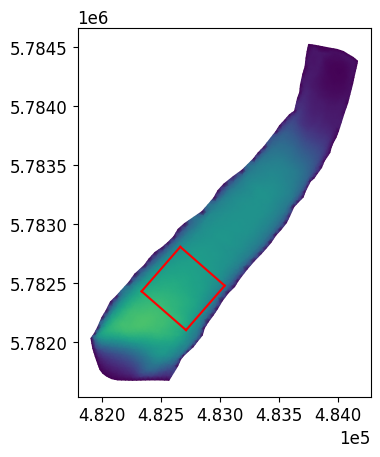

In [46]:
e1 = 4.82332e5
e2 = 4.82660e5
e3 = 4.83037e5
e4 = 4.82709e5


n1 = 5.782430e6
n2 = 5.782807e6
n3 = 5.782478e6
n4 = 5.782101e6

#side1
x = np.linspace(e1,e2,100)
y = np.linspace(n1,n2,100)

#side2
x2 = np.linspace(e2,e3,100)
y2 = np.linspace(n2,n3,100)

#side3
x3 = np.linspace(e3,e4,100)
y3 = np.linspace(n3,n4,100)

#side3
x3 = np.linspace(e3,e4,100)
y3 = np.linspace(n3,n4,100)

#side4
x4 = np.linspace(e4,e1,100)
y4 = np.linspace(n4,n1,100)


distance=sqrt((e1-e2)**2+(n1-n2)**2)
print(distance)


#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.plot(x,y, color='red')
axes.plot(x2,y2, color='red')
axes.plot(x3,y3, color='red')
axes.plot(x4,y4, color='red')

2452.0399670478455
715.8910531638177


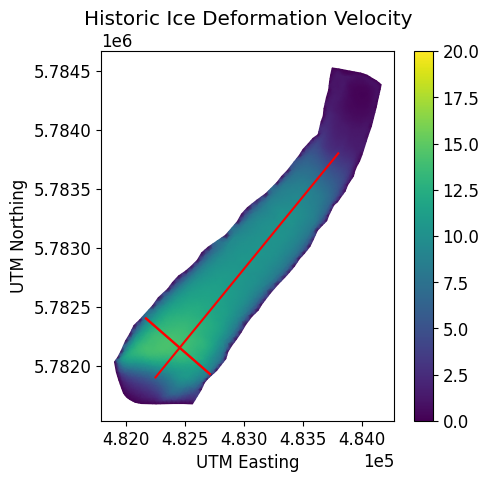

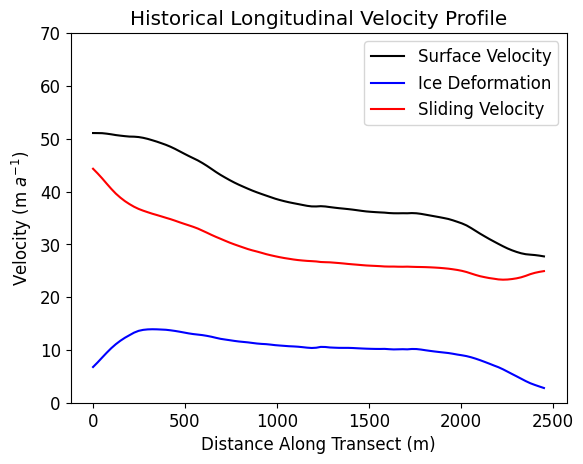

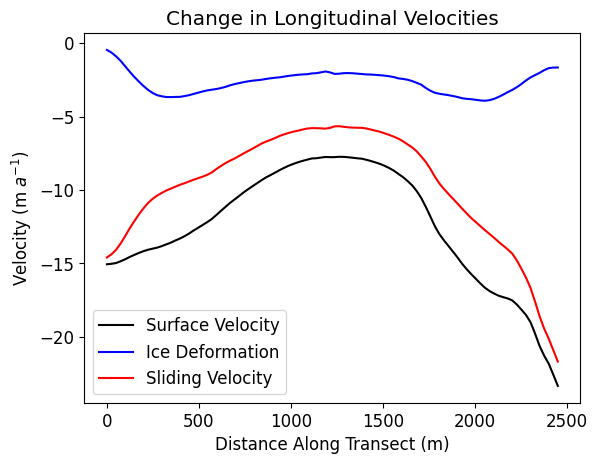

In [47]:

#set up centerline transect
x = np.linspace(4.8225e5,4.838e5,100)
y = np.linspace(5.7819e6,5.7838e6,100)
#z = np.linspace(0,1,100)

distance=sqrt((5.7819e6-5.7838e6)**2+(4.8225e5-4.838e5)**2)
print(distance)

#Raymond cross section
x2 = np.linspace(4.8217e5,4.8271e5,100)
y2 = np.linspace(5.7824e6,5.78193e6,100)

distance=sqrt((5.7824e6-5.78193e6)**2+(4.8217e5-4.8271e5)**2)
print(distance)

#pair the x, y corrdinates into single array
xs = np.zeros((len(x), 2))
xs[:,0] = x
xs[:,1] = y
#xs[:,2] = z

xs2 = np.zeros((len(x2), 2))
xs2[:,0] = x2
xs2[:,1] = y2

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.plot(x,y, color='red')
axes.plot(x2,y2, color='red')
fig.colorbar(colors, ax=axes, fraction=.1, pad=0.04);
axes.set_title('Historic Ice Deformation Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure13.png',dpi=1500, facecolor='w', edgecolor='w',)

axes.plot(x2,y2, color='red')


    
#This is syntax to access modeled value for any grid point within the mesh domain
#check = s([4.8255e5,5.7825e6])
#print(check)

#stored as vx, vy in two columns
plot_shear = np.array(u_shear.at(xs, tolerance=1e-10))
#convert to velocity magnitude
test = ((plot_shear[:,0])**2)
shear_mag = (((plot_shear[:,0])**2) + ((plot_shear[:,1])**2))**0.5
#hs = np.array(h_hist.at(xs, tolerance=1e-10))
#bs = np.array(b.at(xs, tolerance=1e-10))
#us = np.array(u.at(xs, tolerance=1e-10))

#extract surface velocity and shear velocity for transverse/Raymond Profile
plot_shear2 = np.array(u_shear.at(xs2, tolerance=1e-10))
shear_mag2 = (((plot_shear2[:,0])**2) + ((plot_shear2[:,1])**2))**0.5

#Raymond Basal velocities and respective Easting coordinates
#UTM = [482.332, 482.449, 482.567, 482.681]
x_base=[200,360,540,680]
ub = [42.65, 40.81, 38.18, 27.2]

#Upload modern velocity solution at those points
ModLongTotal = np.loadtxt("ModernLongTotal.csv",
                 delimiter=",", dtype=float)

#Upload modern velocity solution at those points
ModLongDef = np.loadtxt("ModernLongDef.csv",
                 delimiter=",", dtype=float)

#Upload modern velocity solution at those points
ModLongBase = np.loadtxt("ModernLongBase.csv",
                 delimiter=",", dtype=float)

x_long = np.linspace(0,2452,100);


#Plot surface velocity and shear velocity magnitude along centerline transect
fig, axes = plt.subplots()
#axes.plot(xs[:, 0] / 1e3, plot_shear, color='black')
axes.plot(x_long, u_inv_mag, label= 'Surface Velocity', color='black')
axes.plot(x_long, shear_mag, label= 'Ice Deformation', color='blue')
axes.plot(x_long, u_inv_mag-shear_mag, label= 'Sliding Velocity', color='red')
axes.legend()
axes.set_title('Historical Longitudinal Velocity Profile');
axes.set_xlabel('Distance Along Transect (m)')
axes.set_ylabel('Velocity (m $a^{-1}$)');
plt.ylim([0, 70])
plt.savefig('/Users/davidpolashenski/Desktop/Figure21.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = plt.subplots()
#axes.plot(xs[:, 0] / 1e3, plot_shear, color='black')
axes.plot(x_long, ModLongTotal-u_inv_mag, label= 'Surface Velocity', color='black')
axes.plot(x_long, ModLongDef-shear_mag, label= 'Ice Deformation', color='blue')
axes.plot(x_long, ModLongBase-(u_inv_mag-shear_mag), label= 'Sliding Velocity', color='red')
axes.legend()
axes.set_title('Change in Longitudinal Velocities');
axes.set_xlabel('Distance Along Transect (m)')
axes.set_ylabel('Velocity (m $a^{-1}$)');
plt.savefig('/Users/davidpolashenski/Desktop/Figure22.png',dpi=1500, facecolor='w', edgecolor='w',)




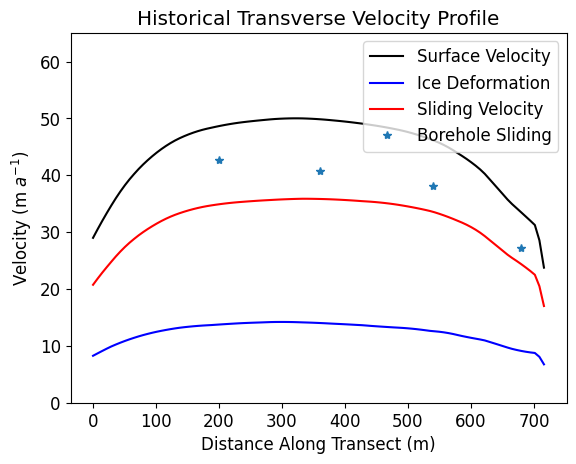

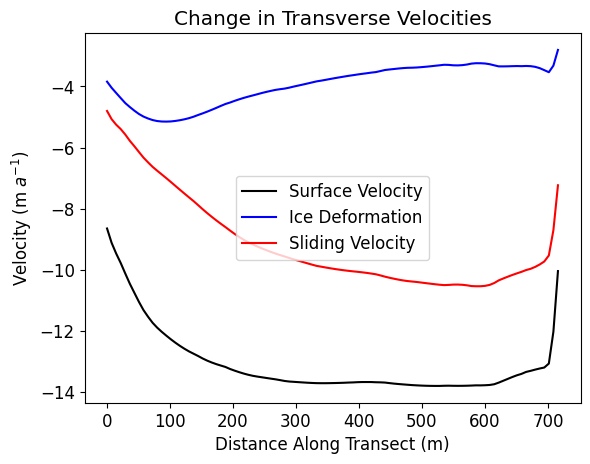

In [48]:
x_lat = np.linspace(0,716,100);

fig, axes = plt.subplots()
#axes.plot(xs[:, 0] / 1e3, plot_shear, color='black')
axes.plot(x_lat, u_inv_mag2, label= 'Surface Velocity', color='black')
axes.plot(x_lat, shear_mag2, label= 'Ice Deformation', color='blue')
axes.plot(x_lat, u_inv_mag2-shear_mag2, label= 'Sliding Velocity', color='red')
axes.plot(x_base,ub, '*', label = 'Borehole Sliding')
axes.legend(loc='upper right')
axes.set_title('Historical Transverse Velocity Profile');
axes.set_xlabel('Distance Along Transect (m)')
axes.set_ylabel('Velocity (m $a^{-1}$)');
plt.ylim([0, 65])
plt.savefig('/Users/davidpolashenski/Desktop/Figure23.png',dpi=1500, facecolor='w', edgecolor='w',)

#Upload modern velocity solution at those points
ModLatTotal = np.loadtxt("ModernLatTotal.csv",
                 delimiter=",", dtype=float)

#Upload modern velocity solution at those points
ModLatDef = np.loadtxt("ModernLatDef.csv",
                 delimiter=",", dtype=float)

#Upload modern velocity solution at those points
ModLatBase = np.loadtxt("ModernLatBase.csv",
                 delimiter=",", dtype=float)

fig, axes = plt.subplots()
#axes.plot(xs[:, 0] / 1e3, plot_shear, color='black')
axes.plot(x_lat, ModLatTotal-u_inv_mag2, label= 'Surface Velocity', color='black')
axes.plot(x_lat, ModLatDef-shear_mag2, label= 'Ice Deformation', color='blue')
axes.plot(x_lat, ModLatBase-(u_inv_mag2-shear_mag2), label= 'Sliding Velocity', color='red')
axes.legend(loc='center')
axes.set_title('Change in Transverse Velocities');
axes.set_xlabel('Distance Along Transect (m)')
axes.set_ylabel('Velocity (m $a^{-1}$)');
plt.savefig('/Users/davidpolashenski/Desktop/Figure24.png',dpi=1500, facecolor='w', edgecolor='w',)


Text(0.5, 1.0, 'Ratio of plug/ depth averaged total velocity')

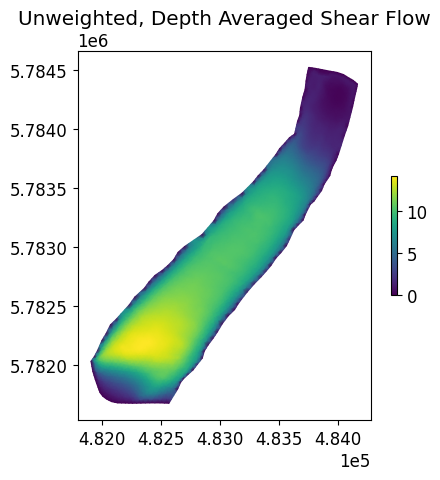

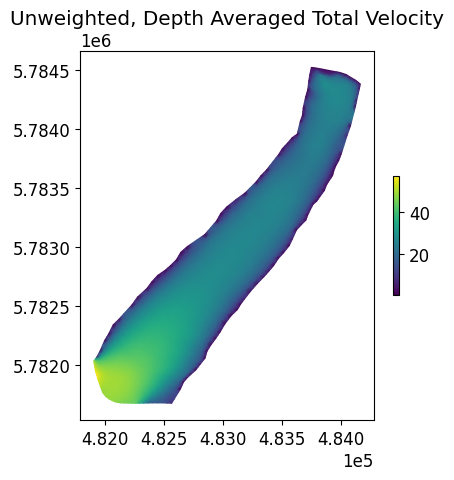

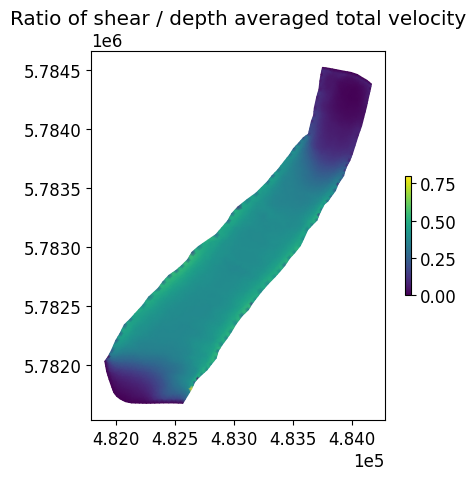

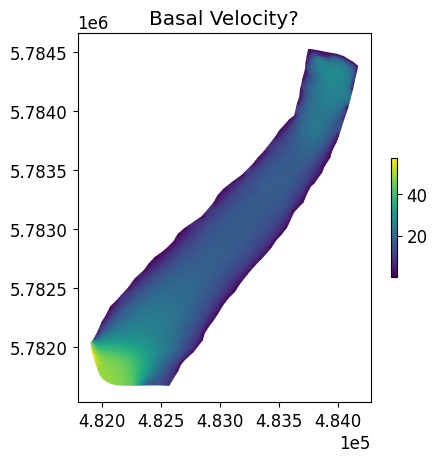

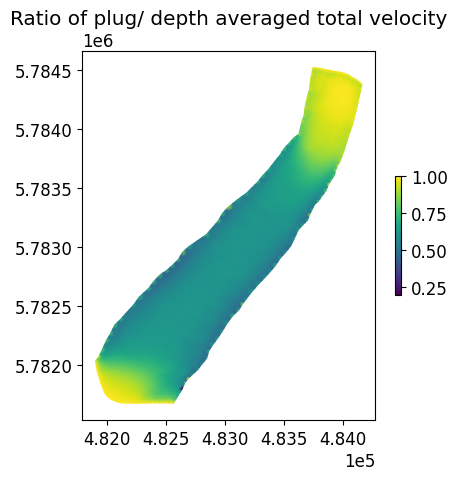

In [49]:
#Unweighted depth average of velocity
#Q2D = firedrake.FunctionSpace(mesh, family='CG', degree=2)
U_shear = sqrt(inner(u_shear, u_shear))
U_avg = sqrt(inner(u_avg, u_avg))

ratio_shear = firedrake.interpolate((U_shear / U_avg), Q2D)
U_base = firedrake.interpolate((1-ratio_shear)*U_avg,Q2D)
ratio_plug = firedrake.interpolate(U_base/U_avg,Q2D)
U_shear = firedrake.interpolate(U_shear,Q2D)
U_avg = firedrake.interpolate(U_avg, Q2D)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_shear, axes=axes)
fig.colorbar(colors, fraction=0.012, pad=0.04);
axes.set_title("Unweighted, Depth Averaged Shear Flow")

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_avg, axes=axes)
fig.colorbar(colors, fraction=0.012, pad=0.04);
axes.set_title("Unweighted, Depth Averaged Total Velocity")

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(ratio_shear, axes=axes)
fig.colorbar(colors, fraction=0.012, pad=0.04);
axes.set_title("Ratio of shear / depth averaged total velocity")

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_base, axes=axes)
fig.colorbar(colors, fraction=0.012, pad=0.04);
axes.set_title("Basal Velocity?")

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(ratio_plug, axes=axes)
fig.colorbar(colors, fraction=0.012, pad=0.04);
axes.set_title("Ratio of plug/ depth averaged total velocity")